In [1]:
import xarray as xr
from dask.distributed import Client
import time
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import sys
import gc
import numpy as np
sys.setrecursionlimit(100000)

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
from matplotlib import path
import scipy.io as sio
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import seaborn as sns
import cmaps
import seapy
import dask
# dask.config.set(scheduler='synchronous')

In [2]:
np.__config__.show()

Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: /Users/onecountrylee/opt/anaconda3/envs/roms/include
    lib directory: /Users/onecountrylee/opt/anaconda3/envs/roms/lib
    name: blas
    openblas configuration: unknown
    pc file directory: /Users/onecountrylee/opt/anaconda3/envs/roms/lib/pkgconfig
    version: 3.9.0
  lapack:
    detection method: internal
    found: true
    include directory: unknown
    lib directory: unknown
    name: dep4326356592
    openblas configuration: unknown
    pc file directory: unknown
    version: 1.26.2
Compilers:
  c:
    commands: arm64-apple-darwin20.0.0-clang
    linker: ld64
    name: clang
    version: 16.0.6
  c++:
    commands: arm64-apple-darwin20.0.0-clang++
    linker: ld64
    name: clang
    version: 16.0.6
  cython:
    commands: cython
    linker: cython
    name: cython
    version: 3.0.5
Machine Information:
  build:
    cpu: aarch64
    endian: little
    family: aarch64
    syste

In [3]:
xr.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.9.21 | packaged by conda-forge | (main, Dec  5 2024, 13:47:18) 
[Clang 18.1.8 ]
python-bits: 64
OS: Darwin
OS-release: 24.2.0
machine: arm64
processor: arm
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: ('en_US', 'UTF-8')
libhdf5: 1.14.4
libnetcdf: 4.9.2

xarray: 2024.3.0
pandas: 2.2.3
numpy: 1.26.2
scipy: 1.13.1
netCDF4: 1.7.2
pydap: None
h5netcdf: None
h5py: 3.13.0
Nio: None
zarr: None
cftime: 1.6.4
nc_time_axis: None
iris: None
bottleneck: 1.4.2
dask: 2023.3.2
distributed: 2023.3.2.1
matplotlib: 3.9.4
cartopy: 0.23.0
seaborn: 0.13.2
numbagg: None
fsspec: 2025.2.0
cupy: None
pint: None
sparse: None
flox: None
numpy_groupies: 0.11.2
setuptools: 64.0.3
pip: 25.0.1
conda: None
pytest: None
mypy: None
IPython: 8.18.1
sphinx: None


In [4]:
#define your root paths
myobsroot = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/INSITU_OBS/'
mynlroot = '/Volumes/WD_3/outputs_SCORRECTION/'
#define your workspace 
nl_workspace = 'outputs_201205/'
obs_workspace = ''
obs_file='sst_withcruiseptpkodc_2012_offshore.nc'
nl_files = "ocean_ecs_his_00*.nc"
grd_file = '/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/workspace_geopolarsst/STORAGE/prior/ocean_ecs_fwd_15461_outer0.nc'

In [5]:
#define your target data duration

start_date = '2012-05-01-12H'
end_date = '2013-05-31-12H'

start_datetime = dt.datetime.strptime(start_date,"%Y-%m-%d-%HH")
end_datetime = dt.datetime.strptime(end_date,"%Y-%m-%d-%HH")
data_len = (end_datetime-start_datetime).days+1 

#define your target variable
obs_var = 6
# 2d situation
# model_var = 'temp_sur' 
#3d situation
model_var = 'temp'

# setting chunk size
x_chunk = int(262/2)
y_chunk = int(362/2)
z_chunk = 10

print('''duration to be validated: from %s to %s, total of %i days.
         target obs variable: %s
         target model variable: %s'''
      %(start_date,end_date,data_len,obs_var,model_var))



duration to be validated: from 2012-05-01-12H to 2013-05-31-12H, total of 396 days.
         target obs variable: 6
         target model variable: temp


In [6]:
# loading observation data
Obs_ds = xr.open_dataset(myobsroot+obs_workspace+obs_file,
                           engine='netcdf4',
                           # chunks={'longitude':260,'latitude':210},
                         
                           )

In [7]:
# extracting cruise observation data with specific time range 
start_obstime = (start_datetime - dt.datetime(1970,1,1)).total_seconds()/3600/24
end_obstime = (end_datetime - dt.datetime(1970,1,1)).total_seconds()/3600/24

this_range = np.where( 
                                (Obs_ds.obs_time.data >= start_obstime) &
                                (Obs_ds.obs_time.data <= end_obstime)  &
                                (Obs_ds.obs_provenance == 200)&
                                (Obs_ds.obs_type == obs_var)
                        )


Obs_ds = Obs_ds.isel(datum=this_range[0]).copy()
timestamp = [ dt.timedelta(int(itime)+0.5)+dt.datetime(1970,1,1) for itime in Obs_ds.obs_time.data]
Obs_ds = Obs_ds.assign_coords(datum=timestamp)


(15461.0, 15472.0)

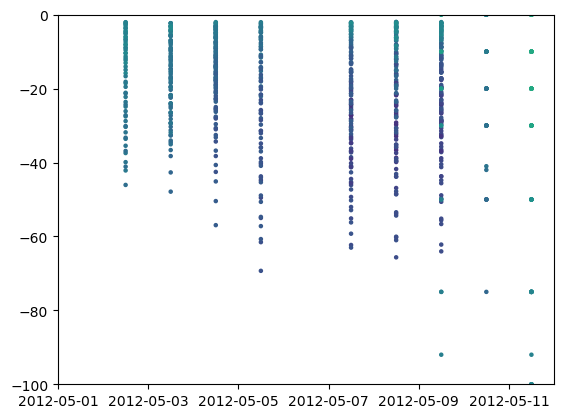

In [8]:
plt.scatter(Obs_ds.datum,Obs_ds.obs_depth,5,Obs_ds.obs_value)
plt.ylim([-100,0])
plt.xlim([dt.datetime(2012,5,1),dt.datetime(2012,5,12)])

In [9]:
# loading forward sst


start = time.time()
nl_ds = xr.open_mfdataset(mynlroot+nl_workspace+nl_files,
                                      engine='netcdf4',coords='minimal',
                                      parallel=True,
                                      # chunks={'eta_rho':y_chunk,'xi_rho':x_chunk,
                                      #      's_rho':z_chunk, # only 3d needed
                                      #      'eta_u':y_chunk,'xi_u':x_chunk,\
                                      #      'eta_v':y_chunk,'xi_v':x_chunk,\
                                      #      'eta_psi':y_chunk,'xi_psi':x_chunk,},
                                       )#.chunk(dict(ocean_time=-1))
end = time.time()
print('loading costing %f min'%((end-start)/60))


loading costing 3.981175 min


In [10]:
# @dask.delayed
def interpolate_data_romsprofile(interp_data):
    interpolation = np.interp(interp_data['obs_depth'],
                              interp_data['roms_depth'],
                              interp_data['roms_data'])
    # interpolation = interp(
    return interpolation

In [11]:
lon_rho2d = nl_ds.lon_rho.data.compute()
lat_rho2d = nl_ds.lat_rho.data.compute()
lon_rho3d = np.tile(lon_rho2d,[len(nl_ds.s_rho),1,1])
lat_rho3d = np.tile(lat_rho2d,[len(nl_ds.s_rho),1,1])

In [12]:
grd_file = '/Volumes/TO_1/outputs_SCORRECTION/ocean_ecs_fwd_15461_outer1.nc'


obs_partition = np.full_like(np.tile(lon_rho2d,
                                     [len(np.unique(Obs_ds.datum)),len(nl_ds.s_rho),1,1]),
                                         np.nan)
nl_partition = np.full_like(obs_partition,np.nan)
depth_partition = np.full_like(obs_partition,np.nan)

# interp_data_list = []
interpolations = []
for i, itime in enumerate(np.unique(Obs_ds.datum)):
    print(itime)
    
    mod_thistime = nl_ds[model_var].sel(ocean_time=itime)
    obs_thistime = Obs_ds.sel(datum=itime)
    zeta_thistime = nl_ds['zeta'].sel(ocean_time=itime).data.compute()
    grid = seapy.model.grid(grd_file,zeta=zeta_thistime); 
    grid.set_depth()
    nldepth_thistime = grid.depth_rho
    depth_partition[i,:,:,:] = nldepth_thistime
    
    obs_lon_thistime = np.round(obs_thistime.obs_lon.data,8)
    obs_lat_thistime = np.round(obs_thistime.obs_lat.data,8)
    obs_x_thistime = obs_thistime.obs_Xgrid.data.astype('int')
    obs_y_thistime = obs_thistime.obs_Ygrid.data.astype('int')
    obs_z_thistime = obs_thistime.obs_Zgrid.data.astype('int')
    obs_depth_thistime = obs_thistime.obs_depth.data
    obs_data_thistime = obs_thistime.obs_value.data

    
    for ix, iy,ilon,ilat in set(zip(obs_x_thistime,obs_y_thistime,obs_lon_thistime,obs_lat_thistime)):
        
        obs_loc = np.where((obs_lon_thistime == ilon) & (obs_lat_thistime==ilat))
        
        mod_nearest = mod_thistime.isel(eta_rho=int(iy),xi_rho=int(ix))
        # print(' ')
        # print(obs_z_thistime[obs_loc])
        # print('OBS LOC      :',ilon,ilat)
        # # print('MOD LOC      :',lon_rho2d[int(iy),int(ix)],
        # #      lat_rho2d[int(iy),int(ix)])
        # print('MOD LOC:',
        #       mod_nearest.lon_rho.data.compute(),mod_nearest.lat_rho.data.compute())
        
        # print(' ')
        interp_data = {'obs_depth':obs_depth_thistime[obs_loc],
                       'roms_depth':nldepth_thistime[:,int(iy),int(ix)],
                       'roms_data':mod_nearest.data}
        # interp_data_list.append(interp_data)
        nl_thisobsloc = interpolate_data_romsprofile(interp_data)
        obs_thisobsloc = obs_data_thistime[obs_loc]
        interpolations.append(nl_thisobsloc)
        zindex_thisobsloc = obs_z_thistime[obs_loc]-1
        # print(nl_thisobsloc)
        # print(obs_data_thistime[obs_loc])
        # print(nldepth_thistime[:,int(iy),int(ix)][obs_z_thistime[obs_loc]-1])
        # print(np.where(nldepth_thistime[obs_z_thistime[obs_loc]-1,int(iy),int(ix)]<np.min(obs_depth_thistime[obs_loc])))
        # depth_partition[i,np.where(nldepth_thistime[obs_z_thistime[obs_loc]-1,int(iy),int(ix)]<np.min(obs_depth_thistime[obs_loc])),int(iy),int(ix)] = np.min(obs_depth_thistime[obs_loc])
        # obs_thisobsloc[nldepth_thistime[obs_z_thistime[obs_loc]-1,int(iy),int(ix)]<np.min(obs_depth_thistime[obs_loc])] = np.nan
        # print(nl_thisobsloc)
        # print(grid.depth_rho[:,int(iy),int(ix)][obs_z_thistime[obs_loc]])
        # print(obs_depth_thistime[obs_loc])
        # print(nl_thisobcloc)
        obs_partition[i,obs_z_thistime[obs_loc]-1,int(iy),int(ix)] = obs_thisobsloc
        nl_partition[i,obs_z_thistime[obs_loc]-1,int(iy),int(ix)] = nl_thisobsloc


2012-05-02T12:00:00.000000000
2012-05-03T12:00:00.000000000
2012-05-04T12:00:00.000000000
2012-05-05T12:00:00.000000000
2012-05-07T12:00:00.000000000
2012-05-08T12:00:00.000000000
2012-05-09T12:00:00.000000000
2012-05-10T12:00:00.000000000
2012-05-11T12:00:00.000000000
2012-05-12T12:00:00.000000000
2012-06-06T12:00:00.000000000
2012-06-08T12:00:00.000000000
2012-06-09T12:00:00.000000000
2012-06-10T12:00:00.000000000
2012-06-11T12:00:00.000000000
2012-06-17T12:00:00.000000000
2012-06-18T12:00:00.000000000
2012-06-22T12:00:00.000000000
2012-06-23T12:00:00.000000000
2012-06-25T12:00:00.000000000
2012-06-26T12:00:00.000000000
2012-06-27T12:00:00.000000000
2012-06-28T12:00:00.000000000
2012-06-29T12:00:00.000000000
2012-07-03T12:00:00.000000000
2012-07-04T12:00:00.000000000
2012-07-05T12:00:00.000000000
2012-07-17T12:00:00.000000000
2012-07-18T12:00:00.000000000
2012-07-19T12:00:00.000000000
2012-07-20T12:00:00.000000000
2012-07-21T12:00:00.000000000
2012-07-22T12:00:00.000000000
2012-07-23

In [13]:
# client = Client(threads_per_worker=4, n_workers=8,memory_limit= '8 GiB')
# client.cluster.scale(8) 
nl_data_obsgrd = xr.DataArray(np.concatenate(interpolations),coords=[Obs_ds.datum],dims='datum')


In [14]:
Obs_ds['nl_value'] = nl_data_obsgrd.copy()


In [15]:
obs_seasonal = {}

obs_seasonal['winter'] = Obs_ds.groupby('datum.season')['DJF']
obs_seasonal['spring'] = Obs_ds.groupby('datum.season')['MAM']
obs_seasonal['summer'] = Obs_ds.groupby('datum.season')['JJA']
obs_seasonal['autumn'] = Obs_ds.groupby('datum.season')['SON']

In [16]:
ds_std = xr.Dataset(
                    {'nl_value':(['ocean_time','s_rho','eta_rho','xi_rho'],nl_partition.copy()),
                     'obs_value':(['ocean_time','s_rho','eta_rho','xi_rho'],obs_partition.copy()),
                     'depth_value':(['ocean_time','s_rho','eta_rho','xi_rho'],depth_partition.copy())},
                    coords={'ocean_time':np.unique(Obs_ds.datum),
                            's_rho': nl_ds.s_rho.data,
                            'lon_rho': (['eta_rho','xi_rho'],nl_ds.lon_rho.data.compute()),
                            'lat_rho':(['eta_rho','xi_rho'],nl_ds.lat_rho.data.compute())}
)
                     

In [17]:
del nl_partition, obs_partition,depth_partition
gc.collect()

334

In [18]:
ds_std

<xarray.Dataset> Size: 6GB
Dimensions:      (ocean_time: 148, s_rho: 20, eta_rho: 362, xi_rho: 242)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 1kB 2012-05-02T12:00:00 ... 2013...
  * s_rho        (s_rho) float64 160B -0.975 -0.925 -0.875 ... -0.075 -0.025
    lon_rho      (eta_rho, xi_rho) float64 701kB 117.7 117.8 ... 129.6 129.7
    lat_rho      (eta_rho, xi_rho) float64 701kB 25.02 25.0 ... 39.45 39.44
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    nl_value     (ocean_time, s_rho, eta_rho, xi_rho) float64 2GB nan ... nan
    obs_value    (ocean_time, s_rho, eta_rho, xi_rho) float64 2GB nan ... nan
    depth_value  (ocean_time, s_rho, eta_rho, xi_rho) float64 2GB -7.312 ... ...

In [19]:
obs_modgrd_seasonal = {}
obs_modgrd_seasonal['winter'] = ds_std.obs_value.groupby('ocean_time.season')['DJF'].mean(dim='ocean_time')
obs_modgrd_seasonal['spring'] = ds_std.obs_value.groupby('ocean_time.season')['MAM'].mean(dim='ocean_time')
obs_modgrd_seasonal['summer'] = ds_std.obs_value.groupby('ocean_time.season')['JJA'].mean(dim='ocean_time')
obs_modgrd_seasonal['autumn'] = ds_std.obs_value.groupby('ocean_time.season')['SON'].mean(dim='ocean_time')

In [20]:
nl_modgrd_seasonal = {}
nl_modgrd_seasonal['winter'] = ds_std.nl_value.groupby('ocean_time.season')['DJF'].mean(dim='ocean_time')
nl_modgrd_seasonal['spring'] = ds_std.nl_value.groupby('ocean_time.season')['MAM'].mean(dim='ocean_time')
nl_modgrd_seasonal['summer'] = ds_std.nl_value.groupby('ocean_time.season')['JJA'].mean(dim='ocean_time')
nl_modgrd_seasonal['autumn'] = ds_std.nl_value.groupby('ocean_time.season')['SON'].mean(dim='ocean_time')

In [21]:
depth_modgrd_seasonal = {}
depth_modgrd_seasonal['winter'] = ds_std.depth_value.groupby('ocean_time.season')['DJF'].mean(dim='ocean_time')
depth_modgrd_seasonal['spring'] = ds_std.depth_value.groupby('ocean_time.season')['MAM'].mean(dim='ocean_time')
depth_modgrd_seasonal['summer'] = ds_std.depth_value.groupby('ocean_time.season')['JJA'].mean(dim='ocean_time')
depth_modgrd_seasonal['autumn'] = ds_std.depth_value.groupby('ocean_time.season')['SON'].mean(dim='ocean_time')

In [22]:
my_sst_color = sio.loadmat('/Volumes/TO_1/roms4dvar_ecs/i4dvar_outputs/'+
                           'LYG_rainbow.mat')['rainbow']
my_sst = LinearSegmentedColormap.from_list('sst',my_sst_color, N = 256)
my_div_color = np.array(  [
                 [0,0,123],
                [9,32,154],
                [22,58,179],
                [34,84,204],
                [47,109,230],
                [63,135,247],
                [95,160,248],
                [137,186,249],
                [182,213,251],
                [228,240,254],
                [255,255,255],
                [250,224,224],
                [242,164,162],
                [237,117,113],
                [235,76,67],
                [233,52,37],
                [212,45,31],
                [188,39,26],
                [164,33,21],
                [140,26,17],
                [117,20,12]
                ])/255
my_div = LinearSegmentedColormap.from_list('div',my_div_color, N = 256)
my_reds = LinearSegmentedColormap.from_list('div',my_div_color[10:], N = 256)
my_palette = sns.color_palette(my_div_color[5:-5])

In [23]:
# #RBL version
# # obs_itp3d = {}
# # nl_itp3d = {}
# # lon_itp3d = {}
# # lat_itp3d = {}
# # depth_itp3d = {}
# # bath_itp3d = {}
# isigma = {'spring':0.5, 'winter':0.5,'summer':0.5,'autumn':0.5}
# ieps = {'spring':1., 'winter':1.,'summer':1.,'autumn':1.}
# iphi = {'spring':'phs1', 'winter':'phs1','summer':'phs1','autumn':'phs1'}
# h = nl_ds.h.isel(ocean_time=0).data
# for iseason in [
#                 'winter',
#                 # 'spring', 
#                 # 'summer',
#                 # 'autumn'
#                 ]:
#     print(iseason)
#     index_valid = np.where(obs_modgrd_seasonal[iseason].notnull().data.ravel())
#     lon_valid = (lon_rho3d.ravel())[index_valid]
#     lat_valid = (lat_rho3d.ravel())[index_valid]
#     depth_valid = (depth_modgrd_seasonal[iseason].data.ravel())[index_valid]
#     obs_valid = (obs_modgrd_seasonal[iseason].data.ravel())[index_valid]
#     nl_valid = (nl_modgrd_seasonal[iseason].data.ravel())[index_valid]
    
#     xi_1D = np.arange(np.floor(np.min(lon_valid)),np.max(lon_valid), 0.05)
#     yi_1D = np.arange(np.floor(np.min(lat_valid)),np.max(lat_valid), 0.05)
#     zi_1D = np.arange(np.floor(np.min(obs_seasonal[iseason].obs_depth)),1,1)
#     xi, yi, zi = np.meshgrid(xi_1D, yi_1D,zi_1D)
#     from scipy.interpolate import  griddata
#     hi = np.tile(griddata((lon_rho2d.ravel(), lat_rho2d.ravel(),),
#                   h.ravel(),
#                  (xi[:,:,-1].ravel(),yi[:,:,-1].ravel()),method='nearest'), [len(zi_1D),1]).copy()
#     hi = np.transpose(hi.reshape([xi.shape[-1],xi.shape[0],xi.shape[1]]),[1,2,0]).copy()

#     lon_itp3d[iseason] = xi.copy()
#     lat_itp3d[iseason] = yi.copy()
#     depth_itp3d[iseason] = zi.copy()
#     bath_itp3d[iseason] = hi.copy()
    
#     from rbf.interpolate import RBFInterpolant
#     from scipy.interpolate import RBFInterpolator
#     print('interpolating...')
#     I_obs = RBFInterpolant(np.c_[lon_valid,lat_valid,depth_valid],obs_valid,sigma=isigma[iseason],eps = ieps[iseason],phi=iphi[iseason])
#     # I_obs = RBFInterpolator(np.c_[lon_valid,lat_valid,depth_valid],obs_valid,smoothing=isigma[iseason],epsilon = ieps[iseason],degree=-1)
#     obs_itp = I_obs(np.c_[xi.ravel(),yi.ravel(),zi.ravel()]).reshape(xi.shape)
#     obs_itp1d = obs_itp.ravel().copy()
#     obs_itp1d[hi.ravel()==7.5] = np.nan
#     obs_itp1d[zi.ravel() < - hi.ravel()] = np.nan
#     obs_itp1d[zi.ravel() < -100] = np.nan
#     obs_itp = obs_itp1d.reshape(xi.shape)
#     obs_itp3d[iseason] = obs_itp.copy()
    
#     I_nl = RBFInterpolant(np.c_[lon_valid,lat_valid,depth_valid],nl_valid,sigma=isigma[iseason],eps = ieps[iseason],phi=iphi[iseason])
#     # I_nl = RBFInterpolator(np.c_[lon_valid,lat_valid,depth_valid],nl_valid,smoothing=isigma[iseason],epsilon = ieps[iseason],degree=-1)
#     nl_itp = I_nl(np.c_[xi.ravel(),yi.ravel(),zi.ravel()]).reshape(xi.shape)
#     nl_itp1d = nl_itp.ravel().copy()
#     nl_itp1d[hi.ravel()==7.5] = np.nan
#     nl_itp1d[zi.ravel() < - hi.ravel()] = np.nan
#     nl_itp1d[zi.ravel() < -100] = np.nan
#     nl_itp = nl_itp1d.reshape(xi.shape)
#     nl_itp3d[iseason] = nl_itp.copy()
#     print('done.')
#     print('plotting...')
#     for k in range(0,int(len(zi_1D)),1):
#         # print(k,k-len(zi_1D),k-len(zi_1D)+1, )
#         depth_index = np.where((depth_valid<=k-len(zi_1D)+1) & (depth_valid>k-len(zi_1D)))
#         fig = plt.figure(figsize=(5,5))
#         ax = fig.add_subplot()
#         sc = ax.scatter(lon_valid[depth_index],
#                         lat_valid[depth_index],
#                         # obs_seasonal['winter'].obs_depth,
#                    s=5,
#                         c=obs_valid[depth_index],
#                         marker = 's',vmin=5,vmax=35,edgecolor='k',cmap='jet',
#                         zorder=3)
    
        
#         cf = ax.pcolormesh(xi[:,:,-1],
#                         yi[:,:,-1],
#                         obs_itp3d[iseason][:,:,k],vmin=5,vmax=35,cmap='jet',)
#         # sc = ax.pcolor(x,
#         #                 y,
#         #                 z,cmap=my_sst,vmin=5,vmax=30)
#         plt.colorbar(cf,ticks=np.arange(5,40,5))
#         if np.abs(k-len(zi_1D)+1) <= 100:
#             fig.savefig('./obs_itp/TEMP/%s_d%i_mask_sig05.png'%(iseason,np.abs(k-len(zi_1D)+1)),dpi=400)
#         plt.close()
#         fig = plt.figure(figsize=(5,5))
#         ax = fig.add_subplot()
#         sc = ax.scatter(lon_valid[depth_index],
#                         lat_valid[depth_index],
#                         # obs_seasonal['winter'].obs_depth,
#                    s=5,
#                         c=obs_valid[depth_index],
#                         marker = 's',vmin=5,vmax=35,edgecolor='k',cmap='jet',
#                         zorder=3)
    
        
#         cf = ax.pcolormesh(xi[:,:,-1],
#                         yi[:,:,-1],
#                         nl_itp3d[iseason][:,:,k],vmin=5,vmax=35,cmap='jet',)
#         # sc = ax.pcolor(x,
#         #                 y,
#         #                 z,cmap=my_sst,vmin=5,vmax=30)
#         plt.colorbar(cf,ticks=np.arange(5,40,5))
#         if np.abs(k-len(zi_1D)+1) <= 100:
#             fig.savefig('./obs_itp/TEMP/%s_d%i_nl_sig05.png'%(iseason,np.abs(k-len(zi_1D)+1)),dpi=400)
#         plt.close()
#     print('done.')
#     # plt.xlim([dt.datetime(2012,5,1),dt.datetime(2012,5,12)])

In [24]:
@dask.delayed
def interpolate_data(loc,value,loc_intp):
    from scipy.interpolate import  griddata
    interpolation = griddata(loc,
                              value,
                              loc_intp,method='linear')

    return interpolation

In [25]:
#RBL for vertical
obs_itpv = {}
nl_itpv = {}
lon_itpv = {}
lat_itpv = {}
depth_itpv = {}
bath_itpv = {}
isigma = {'spring':0.1, 'winter':0.1,'summer':0.1,'autumn':0.1}
ieps = {'spring':2., 'winter':2,'summer':2.,'autumn':2.}
# iphi = {'spring':'mat32', 'winter':'phs2','summer':'mat32','autumn':'mat32'}
ikernel = {'spring':'thin_plate_spline', 'winter':'thin_plate_spline','summer':'thin_plate_spline','autumn':'thin_plate_spline'}
h = nl_ds.h.isel(ocean_time=0).data
z_rho3d = np.transpose(np.tile(np.linspace(-1,0,20),[lon_rho2d.shape[0],lon_rho2d.shape[1],1]),[2,0,1])
for iseason in [
                'winter',
                'spring', 
                'summer',
                'autumn'
                ]:
    print(iseason)
    index_valid = np.where(obs_modgrd_seasonal[iseason].notnull().data.ravel())
    lon_valid = (lon_rho3d.ravel())[index_valid]
    lat_valid = (lat_rho3d.ravel())[index_valid]
    depth_valid = (depth_modgrd_seasonal[iseason].data.ravel())[index_valid]
    obs_valid = (obs_modgrd_seasonal[iseason].data.ravel())[index_valid]
    nl_valid = (nl_modgrd_seasonal[iseason].data.ravel())[index_valid]
    z_valid = (z_rho3d.ravel())[index_valid]
    xi_1D = np.arange(np.floor(np.min(lon_valid)),np.max(lon_valid), 0.05)
    yi_1D = np.arange(np.floor(np.min(lat_valid)),np.max(lat_valid), 0.05)
    # zi_1D = np.arange(np.floor(np.min(obs_seasonal[iseason].obs_depth)),1,1)
    # zi_1D = np.arange[-140,-[-140,-110,-80,-50,-30,-20,-10,0]
    zi_1D = np.linspace(-1,0,20)
    xi, yi, zi = np.meshgrid(xi_1D, yi_1D,zi_1D)
    from scipy.interpolate import  griddata
    hi = np.tile(griddata((lon_rho2d.ravel(), lat_rho2d.ravel(),),
                  h.ravel(),
                 (xi[:,:,-1].ravel(),yi[:,:,-1].ravel()),method='nearest'), [len(zi_1D),1]).copy()
    hi = np.transpose(hi.reshape([xi.shape[-1],xi.shape[0],xi.shape[1]]),[1,2,0]).copy()

    interpolations = []

    for i in range(0,20):
        interpolations.append(interpolate_data((lon_rho2d.ravel(), lat_rho2d.ravel()),
                                       depth_modgrd_seasonal[iseason].data[i,:,:].ravel(),
                                       (xi[:,:,-1].ravel(),yi[:,:,-1].ravel())))
    
    depth_intpi = dask.compute(interpolations)
    depth_itpv[iseason] = (np.array(depth_intpi)[0].T).reshape(xi.shape)
                                    
    lon_itpv[iseason] = xi.copy()
    lat_itpv[iseason] = yi.copy()
    # depth_itpv[iseason] = zi.copy()
    bath_itpv[iseason] = hi.copy()
    print('interpolating...')
    from rbf.interpolate import RBFInterpolant
    from scipy.interpolate import RBFInterpolator
    # I_obs = RBFInterpolant(np.c_[lon_valid,lat_valid,depth_valid],obs_valid,sigma=isigma[iseason],eps = ieps[iseason],phi=iphi[iseason])
    I_obs = RBFInterpolator(np.c_[lon_valid,lat_valid,z_valid],obs_valid,smoothing=isigma[iseason],epsilon = ieps[iseason],kernel=ikernel[iseason])
    obs_itp = I_obs(np.c_[xi.ravel(),yi.ravel(),zi.ravel()]).reshape(xi.shape)
    obs_itp1d = obs_itp.ravel().copy()
    obs_itp1d[hi.ravel()==7.5] = np.nan
    # obs_itp1d[zi.ravel() < - hi.ravel()] = np.nan
    # obs_itp1d[zi.ravel() < -100] = np.nan
    obs_itp = obs_itp1d.reshape(xi.shape)
    obs_itpv[iseason] = obs_itp.copy()
    
    # I_nl = RBFInterpolant(np.c_[lon_valid,lat_valid,depth_valid],nl_valid,sigma=isigma[iseason],eps = ieps[iseason],phi=iphi[iseason])
    I_nl = RBFInterpolator(np.c_[lon_valid,lat_valid,z_valid],nl_valid,smoothing=isigma[iseason],epsilon = ieps[iseason],kernel=ikernel[iseason])
    nl_itp = I_nl(np.c_[xi.ravel(),yi.ravel(),zi.ravel()]).reshape(xi.shape)
    nl_itp1d = nl_itp.ravel().copy()
    nl_itp1d[hi.ravel()==7.5] = np.nan
    # nl_itp1d[zi.ravel() < - hi.ravel()] = np.nan
    # nl_itp1d[zi.ravel() < -100] = np.nan
    nl_itp = nl_itp1d.reshape(xi.shape)
    nl_itpv[iseason] = nl_itp.copy()
    print('done.')

winter
interpolating...
done.
spring
interpolating...
done.
summer
interpolating...
done.
autumn
interpolating...
done.


In [26]:
#RBL 2D from vertical stretched version itpv
obs_itp3d = {}
nl_itp3d = {}
lon_itp3d = {}
lat_itp3d = {}
depth_itp3d = {}
bath_itp3d = {}
imin = {'spring':5., 'winter':5.,'summer':10.,'autumn':10.}
imax = {'spring':25., 'winter':15.,'summer':35.,'autumn':30.}
isigma = {'spring':5., 'winter':5.,'summer':5.,'autumn':5.}
ieps = {'spring':5., 'winter':5.,'summer':5.,'autumn':5.}
iphi = {'spring':'phs2', 'winter':'phs2','summer':'phs2','autumn':'phs2'}
h = nl_ds.h.isel(ocean_time=0).data
for iseason in [
                'winter',
                'spring', 
                'summer',
                'autumn'
                ]:
    print(iseason)
    index_valid = np.where(obs_modgrd_seasonal[iseason].notnull().data.ravel())
    lon_valid = (lon_rho3d.ravel())[index_valid]
    lat_valid = (lat_rho3d.ravel())[index_valid]
    depth_valid = (depth_modgrd_seasonal[iseason].data.ravel())[index_valid]
    obs_valid = (obs_modgrd_seasonal[iseason].data.ravel())[index_valid]
    nl_valid = (nl_modgrd_seasonal[iseason].data.ravel())[index_valid]
    
    xi_1D = np.arange(np.floor(np.min(lon_valid)),np.max(lon_valid), 0.05)
    yi_1D = np.arange(np.floor(np.min(lat_valid)),np.max(lat_valid), 0.05)
    zi_1D = np.arange(-100,1,1)
    xi, yi, zi = np.meshgrid(xi_1D, yi_1D,zi_1D)
    from scipy.interpolate import  griddata
    hi = (griddata((lon_rho2d.ravel(), lat_rho2d.ravel(),),
                  h.ravel(),
                 (xi[:,:,-1].ravel(),yi[:,:,-1].ravel()),method='nearest').reshape(xi[:,:,-1].shape)).copy()
    # hi = np.transpose(hi.reshape([xi.shape[-1],xi.shape[0],xi.shape[1]]),[1,2,0]).copy()

    lon_itp3d[iseason] = xi.copy()
    lat_itp3d[iseason] = yi.copy()
    depth_itp3d[iseason] = zi.copy()
    bath_itp3d[iseason] = hi.copy()

    obs_itp3d[iseason] = np.full_like(xi,np.nan)
    nl_itp3d[iseason] = np.full_like(xi,np.nan)
    lon_itpvi = lon_itpv[iseason].ravel()
    lat_itpvi = lat_itpv[iseason].ravel()
    obs_itpvi = obs_itpv[iseason].ravel()
    nl_itpvi = nl_itpv[iseason].ravel()
    print('interpolating... & plotting...')
    for k in range(0,len(zi_1D)-1,1):
        
        # print(k,zi_1D[k],zi_1D[k+1] )
        depth_index = np.where((depth_valid<=zi_1D[k+1]) & (depth_valid>zi_1D[k]))
        depthv_index = np.where((depth_itpv[iseason].ravel()<=zi_1D[k+1]) & 
                                (depth_itpv[iseason].ravel()>zi_1D[k]) & 
                                (~np.isnan(obs_itpv[iseason].ravel())) &
                                (~np.isnan(nl_itpv[iseason]).ravel())) ##### index valud CAN NOT have NaN number!!!!!!
        from rbf.interpolate import RBFInterpolant
        from scipy.interpolate import RBFInterpolator

        
        # I_obs = RBFInterpolant(np.c_[lon_itpvi[depthv_index],
        #                              lat_itpvi[depthv_index],
        #                              ],
        #                        obs_itpvi[depthv_index],
        #                        sigma=isigma[iseason],
        #                        eps = ieps[iseason],
        #                        phi=iphi[iseason],order=1)
        # I_obs = RBFInterpolator(np.c_[lon_valid,lat_valid,depth_valid],obs_valid,smoothing=isigma[iseason],epsilon = ieps[iseason],degree=-1)
        obs_itp = griddata(np.c_[lon_itpvi[depthv_index],
                                     lat_itpvi[depthv_index],
                                     ],
                               obs_itpvi[depthv_index],
                               np.c_[xi[:,:,-1].ravel(),yi[:,:,-1].ravel()],method='linear').reshape(xi[:,:,-1].shape)
        obs_itp1d = obs_itp.ravel().copy()
        obs_itp1d[hi.ravel()==7.5] = np.nan
        obs_itp1d[zi[:,:,k].ravel() < - hi.ravel()] = np.nan
        obs_itp = obs_itp1d.reshape(xi[:,:,-1].shape)
        obs_itp3d[iseason][:,:,k] = obs_itp.copy()
        # I_nl = griddata(np.c_[lon_itpvi[depthv_index],
        #                              lat_itpvi[depthv_index],
        #                              ],
        #                        nl_itpvi[depthv_index],
        #                       sigma=isigma[iseason],
        #                       eps = ieps[iseason],
        #                       phi=iphi[iseason],order=1
        #                )
        # I_nl = RBFInterpolator(np.c_[lon_valid,lat_valid,depth_valid],nl_valid,smoothing=isigma[iseason],epsilon = ieps[iseason],degree=-1)
        nl_itp = griddata(np.c_[lon_itpvi[depthv_index],
                                     lat_itpvi[depthv_index],
                                     ],
                               nl_itpvi[depthv_index],
                               np.c_[xi[:,:,-1].ravel(),yi[:,:,-1].ravel()],method='linear').reshape(xi[:,:,-1].shape)
        nl_itp1d = nl_itp.ravel().copy()
        nl_itp1d[hi.ravel()==7.5] = np.nan
        nl_itp1d[zi[:,:,k].ravel() < - hi.ravel()] = np.nan
        nl_itp = nl_itp1d.reshape(xi[:,:,-1].shape)
        nl_itp3d[iseason][:,:,k] = nl_itp.copy()
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot()
        sc = ax.scatter(lon_valid[depth_index],
                        lat_valid[depth_index],
                        # obs_seasonal['winter'].obs_depth,
                   s=5,
                        c=obs_valid[depth_index],
                        marker = 's',vmin=imin[iseason],vmax=imax[iseason],edgecolor='k',cmap='jet',
                        zorder=3)
    
        
        cf = ax.pcolormesh(xi[:,:,-1],
                        yi[:,:,-1],
                        obs_itp3d[iseason][:,:,k],vmin=imin[iseason],vmax=imax[iseason],cmap='jet',)
        # sc = ax.pcolor(x,
        #                 y,
        #                 z,cmap=my_sst,vmin=5,vmax=30)
        plt.colorbar(cf,ticks=np.arange(5,40,5))
        if np.abs(k-len(zi_1D)+1) <= 100:
            fig.savefig('./obs_itp/TEMP/%s_d%i_mask_vcoord_phs2201.png'%(iseason,np.abs(zi_1D[k])-1),dpi=400)
        plt.close()
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot()
        sc = ax.scatter(lon_valid[depth_index],
                        lat_valid[depth_index],
                        # obs_seasonal['winter'].obs_depth,
                   s=5,
                        c=obs_valid[depth_index],
                        marker = 's',vmin=imin[iseason],vmax=imax[iseason],edgecolor='k',cmap='jet',
                        zorder=3)
    
        
        cf = ax.pcolormesh(xi[:,:,-1],
                        yi[:,:,-1],
                        nl_itp3d[iseason][:,:,k],vmin=imin[iseason],vmax=imax[iseason],cmap='jet',)
        # sc = ax.pcolor(x,
        #                 y,
        #                 z,cmap=my_sst,vmin=5,vmax=30)
        plt.colorbar(cf,ticks=np.arange(5,40,5))
    
        plt.savefig('./obs_itp/TEMP/%s_d%i_nl_vcoord_phs2201.png'%(iseason,np.abs(zi_1D[k])-1),dpi=400)
        # print(np.abs(zi_1D[k])-1)
        plt.close()
    print('done.')
    # plt.xlim([dt.datetime(2012,5,1),dt.datetime(2012,5,12)])

winter
interpolating... & plotting...
done.
spring
interpolating... & plotting...
done.
summer
interpolating... & plotting...
done.
autumn
interpolating... & plotting...
done.


In [27]:
def plot_lonsection_bath(ax,lon_section,bath_section):

    ax.plot(np.r_[lon_section[0],
                        lon_section,
                        lon_section[-1],
                        lon_section[0]-5,
                        lon_section[0]-5,
                       ],
                  -np.r_[0,
                         bath_section,
                         np.max(bath_section)+100,
                         np.max(bath_section)+100,
                         0
                ],'k-')
    ax.fill(np.r_[lon_section[0],
                        lon_section,
                        lon_section[-1],
                        lon_section[0]-5,
                        lon_section[0]-5,
                       ],
                  -np.r_[0,
                         bath_section,
                         np.max(bath_section)+100,
                         np.max(bath_section)+100,
                         0
                ],'lightgray')

def set_timeseries_bg(ax):
    import matplotlib.dates as mdates
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth(2)
    ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)
    ax.xaxis.set_major_formatter(
        mdates.ConciseDateFormatter(axs[2].xaxis.get_major_locator()))    

def set_scatter_bg(ax):
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth(2)
    ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)



def set_lonsection_bg(ax):
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth(2)
    ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)

    ax.xaxis.set_major_formatter(lon_formatter)

    
def set_area_pcolor_bg(lon_bdy, lat_bdy, ax):

    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth(2)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgrey',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    # ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+4,4),crs=ccrs.PlateCarree())
    # ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1],4),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)

def set_ecs_pcolor_bg(ax):
    lon_bdy = [116,136];
    lat_bdy = [20,42];
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth(2)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgrey',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+4,4),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0],lat_bdy[-1],4),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)


def add_geo_colorbar(sc,ax,ticks_pos):
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="6.6%", pad=0.1, axes_class=plt.Axes)

    ax_cb = fig.add_axes(ax_cb)
    plt.colorbar(sc, cax=ax_cb,ticks=ticks_pos,)
    ax_cb.tick_params(direction = 'out', length =5, width = 2, labelsize = 12)
    for bnd in ax_cb.spines.keys():
        ax_cb.spines[bnd].set_linewidth(2)
    return ax_cb

def set_ys_pcolor_bg(ax):
    lon_bdy = [119,127];
    lat_bdy = [31.5,37.5];
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth(2)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgrey',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+2,2),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0]+0.5,lat_bdy[-1],2),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)

def set_bh_pcolor_bg(ax):
    lon_bdy = [116.5,123.5];
    lat_bdy = [35.5,41.5];
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth(2)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgrey',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1]+2,2),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0]+0.5,lat_bdy[-1],2),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)
    
def set_cre_pcolor_bg(ax):
    lon_bdy = [119.5,128.5];
    lat_bdy = [27,34];
    for bnd in ax.spines.keys():
        ax.spines[bnd].set_linewidth(2)
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), color = 'gray',zorder = 2,linewidth =1)
    ax.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgrey',zorder = -1)
    ax.set_extent((lon_bdy[0],lon_bdy[-1],lat_bdy[0],lat_bdy[-1]),crs = ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_bdy[0],lon_bdy[-1],2),crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_bdy[0]+0.5,lat_bdy[-1],2),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                    degree_symbol='°',
                                    dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                        degree_symbol='°')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.tick_params(direction = 'out',width =2,length=5, labelsize = 12,top = 0, right = 0)
    

def plot_sea_area_bry(lonbry,latbry,ax):
    ax.plot([lonbry[0],lonbry[-1],lonbry[-1],lonbry[0],lonbry[0]],
        [latbry[0],latbry[0],latbry[-1],latbry[-1],latbry[0]]
              ,'r--',linewidth = 3,
              transform=ccrs.PlateCarree(),zorder=1)
    
def get_index_in_area(lon_outer,lat_outer,Xbox,Ybox):
    from matplotlib import path
    box = [(x,y) for x,y  in zip(Xbox, Ybox)]
    polygon = path.Path(box)
    inarea = polygon.contains_points([(x_outer,y_outer) for x_outer,y_outer in zip(lon_outer,lat_outer)])
    return inarea

scatter plot overall validation

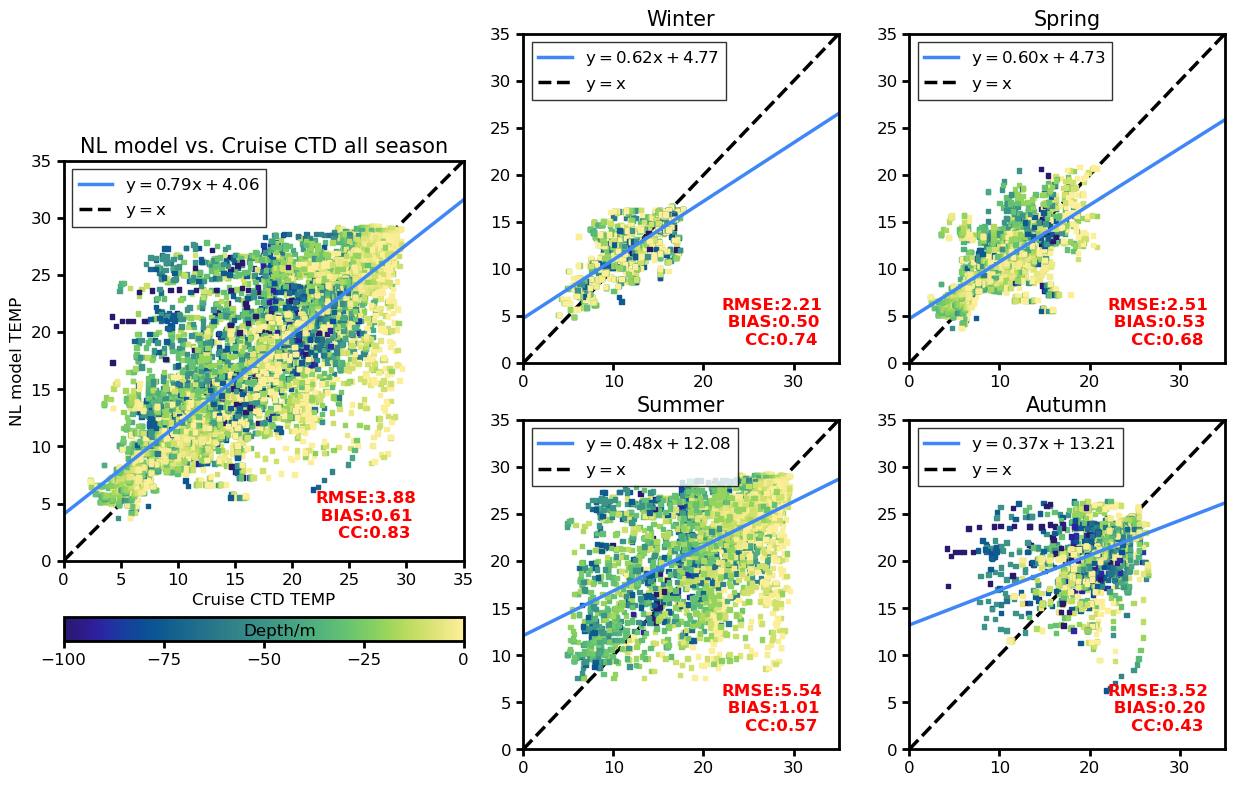

In [400]:

axs = []
fig = plt.figure(figsize=(8,8))
spec = fig.add_gridspec(ncols=2, nrows=2)
axs.append(fig.add_subplot(spec[0,0])) #0
axs.append(fig.add_subplot(spec[0,1]))  #1

axs.append(fig.add_subplot(spec[1,0]))  #3
axs.append(fig.add_subplot(spec[1,1]))  #4

fig.tight_layout(pad=2)
icmap = cmaps.cmocean_haline

iax=0
iseason = 'winter'
set_scatter_bg(axs[iax])
sc = axs[iax].scatter(obs_seasonal[iseason].obs_value.data,obs_seasonal[iseason].nl_value.data,10,obs_seasonal[iseason].obs_depth,
                      marker = 's',
                    vmin=-100,vmax=0,cmap=icmap,
                    )
cc = xr.corr(obs_seasonal[iseason].nl_value,obs_seasonal[iseason].obs_value,dim='datum').data
bias = (obs_seasonal[iseason].nl_value-obs_seasonal[iseason].obs_value).mean(dim='datum')
std = (obs_seasonal[iseason].nl_value-obs_seasonal[iseason].obs_value).std(dim='datum')
rmse = np.sqrt(bias**2 +std**2)

z = np.polyfit(obs_seasonal[iseason].obs_value.data,obs_seasonal[iseason].nl_value.data,1)
p = np.poly1d(z)
# axs[iax].set

axs[iax].plot(np.arange(0,40),p(np.arange(0,40)),
              color=my_palette[0],linewidth=2.5,
              label = "$\mathsf{y=%.2fx+%.2f}$"%(p[1],p[0]))
axs[iax].plot(np.arange(0,40),np.arange(0,40),
              'k--',linewidth=2.5,
              label = "$\mathsf{y=x}$",
              zorder=0
             )
axs[iax].text(22,2,'RMSE:%.2f\n BIAS:%.2f\n    CC:%.2f'%(rmse,bias,cc),
             color='r',
              fontsize=12,
              fontweight='bold',)

axs[iax].set_xlim([0,35])
axs[iax].set_ylim([0,35])
axs[iax].legend(loc='upper left',fancybox=False,fontsize = 12,edgecolor='k')

axs[iax].set_title('%s'%(iseason.capitalize()),fontsize=15)

iax=1
iseason = 'spring'
set_scatter_bg(axs[iax])
sc = axs[iax].scatter(obs_seasonal[iseason].obs_value.data,obs_seasonal[iseason].nl_value.data,10,obs_seasonal[iseason].obs_depth,
                      marker = 's',
                    vmin=-100,vmax=0,cmap=icmap,
                    )
cc = xr.corr(obs_seasonal[iseason].nl_value,obs_seasonal[iseason].obs_value,dim='datum').data
bias = (obs_seasonal[iseason].nl_value-obs_seasonal[iseason].obs_value).mean(dim='datum')
std = (obs_seasonal[iseason].nl_value-obs_seasonal[iseason].obs_value).std(dim='datum')
rmse = np.sqrt(bias**2 +std**2)

z = np.polyfit(obs_seasonal[iseason].obs_value.data,obs_seasonal[iseason].nl_value.data,1)
p = np.poly1d(z)
# axs[iax].set

axs[iax].plot(np.arange(0,40),p(np.arange(0,40)),
              color=my_palette[0],linewidth=2.5,
              label = "$\mathsf{y=%.2fx+%.2f}$"%(p[1],p[0]))
axs[iax].plot(np.arange(0,40),np.arange(0,40),
              'k--',linewidth=2.5,
              label = "$\mathsf{y=x}$",
              zorder=0
             )
axs[iax].text(22,2,'RMSE:%.2f\n BIAS:%.2f\n    CC:%.2f'%(rmse,bias,cc),
             color='r',
              fontsize=12,
              fontweight='bold',)

axs[iax].set_xlim([0,35])
axs[iax].set_ylim([0,35])
axs[iax].legend(loc='upper left',fancybox=False,fontsize = 12,edgecolor='k')

axs[iax].set_title('%s'%(iseason.capitalize()),fontsize=15)

iax=2
iseason = 'summer'
set_scatter_bg(axs[iax])
sc = axs[iax].scatter(obs_seasonal[iseason].obs_value.data,obs_seasonal[iseason].nl_value.data,10,obs_seasonal[iseason].obs_depth,
                      marker = 's',
                    vmin=-100,vmax=0,cmap=icmap,
                    )
cc = xr.corr(obs_seasonal[iseason].nl_value,obs_seasonal[iseason].obs_value,dim='datum').data
bias = (obs_seasonal[iseason].nl_value-obs_seasonal[iseason].obs_value).mean(dim='datum')
std = (obs_seasonal[iseason].nl_value-obs_seasonal[iseason].obs_value).std(dim='datum')
rmse = np.sqrt(bias**2 +std**2)

z = np.polyfit(obs_seasonal[iseason].obs_value.data,obs_seasonal[iseason].nl_value.data,1)
p = np.poly1d(z)
# axs[iax].set

axs[iax].plot(np.arange(0,40),p(np.arange(0,40)),
              color=my_palette[0],linewidth=2.5,
              label = "$\mathsf{y=%.2fx+%.2f}$"%(p[1],p[0]))
axs[iax].plot(np.arange(0,40),np.arange(0,40),
              'k--',linewidth=2.5,
              label = "$\mathsf{y=x}$",
              zorder=0
             )
axs[iax].text(22,2,'RMSE:%.2f\n BIAS:%.2f\n    CC:%.2f'%(rmse,bias,cc),
             color='r',
              fontsize=12,
              fontweight='bold',)

axs[iax].set_xlim([0,35])
axs[iax].set_ylim([0,35])
axs[iax].legend(loc='upper left',fancybox=False,fontsize = 12,edgecolor='k')

axs[iax].set_title('%s'%(iseason.capitalize()),fontsize=15)

iax=3
iseason = 'autumn'
set_scatter_bg(axs[iax])
sc = axs[iax].scatter(obs_seasonal[iseason].obs_value.data,obs_seasonal[iseason].nl_value.data,10,obs_seasonal[iseason].obs_depth,
                      marker = 's',
                    vmin=-100,vmax=0,cmap=icmap,
                    )
cc = xr.corr(obs_seasonal[iseason].nl_value,obs_seasonal[iseason].obs_value,dim='datum').data
bias = (obs_seasonal[iseason].nl_value-obs_seasonal[iseason].obs_value).mean(dim='datum')
std = (obs_seasonal[iseason].nl_value-obs_seasonal[iseason].obs_value).std(dim='datum')
rmse = np.sqrt(bias**2 +std**2)

z = np.polyfit(obs_seasonal[iseason].obs_value.data,obs_seasonal[iseason].nl_value.data,1)
p = np.poly1d(z)
# axs[iax].set

axs[iax].plot(np.arange(0,40),p(np.arange(0,40)),
              color=my_palette[0],linewidth=2.5,
              label = "$\mathsf{y=%.2fx+%.2f}$"%(p[1],p[0]))
axs[iax].plot(np.arange(0,40),np.arange(0,40),
              'k--',linewidth=2.5,
              label = "$\mathsf{y=x}$",
              zorder=0
             )
axs[iax].text(22,2,'RMSE:%.2f\n BIAS:%.2f\n    CC:%.2f'%(rmse,bias,cc),
             color='r',
              fontsize=12,
              fontweight='bold',)

axs[iax].set_xlim([0,35])
axs[iax].set_ylim([0,35])
axs[iax].legend(loc='upper left',fancybox=False,fontsize = 12,edgecolor='k')

axs[iax].set_title('%s'%(iseason.capitalize()),fontsize=15)








position=fig.add_axes([ -0.5, 0.3,0.5, 0.5, ])
set_scatter_bg(position)
sc = position.scatter(Obs_ds.obs_value.data,Obs_ds.nl_value.data,10,Obs_ds.obs_depth,marker = 's',
                    vmin=-100,vmax=0,cmap=icmap,
                    )
cc = xr.corr(Obs_ds.nl_value,Obs_ds.obs_value,dim='datum').data
bias = (Obs_ds.nl_value-Obs_ds.obs_value).mean(dim='datum')
std = (Obs_ds.nl_value-Obs_ds.obs_value).std(dim='datum')
rmse = np.sqrt(bias**2+std**2)
z = np.polyfit(Obs_ds.obs_value.data,Obs_ds.nl_value.data,1)
p = np.poly1d(z)
# position.set

position.plot(np.arange(0,40),p(np.arange(0,40)),
              color=my_palette[0],linewidth=2.5,
              label = "$\mathsf{y=%.2fx+%.2f}$"%(p[1],p[0]))
position.plot(np.arange(0,40),np.arange(0,40),
              'k--',linewidth=2.5,
              label = "$\mathsf{y=x}$",
              zorder=0
             )

position.set_xlim([0,35])
position.set_ylim([0,35])
position.legend(loc='upper left',fancybox=False,fontsize = 12,edgecolor='k')
position.set_xlabel('Cruise CTD TEMP',fontsize=12)
position.set_ylabel('NL model TEMP',fontsize=12)
position.set_title('NL model vs. Cruise CTD all season',fontsize=15)
position.text(22,2,'RMSE:%.2f\n BIAS:%.2f\n    CC:%.2f'%(rmse,bias,cc),
             color='r',
              fontsize=12,
              fontweight='bold',)
cb_position=fig.add_axes([ -0.5, 0.2,0.5, 0.03, ])

cb = fig.colorbar(sc, cax = cb_position,orientation='horizontal',
                  ticks = np.arange(-100,25,25))
for bnd in cb_position.spines.keys():
    cb_position.spines[bnd].set_linewidth(2)
cb_position.tick_params(direction = 'out', length =5, width = 2, labelsize = 12)
cb_position.text(-55,0.2,'Depth/m',fontsize=12)
plt.savefig('/Volumes/LC_1/fig_thesis/nl_scatter_temp.png',bbox_inches='tight',dpi=400)
plt.savefig('/Volumes/LC_1/fig_thesis/nl_scatter_temp.pdf',bbox_inches='tight',dpi=400)

winter temp horizontal  validation

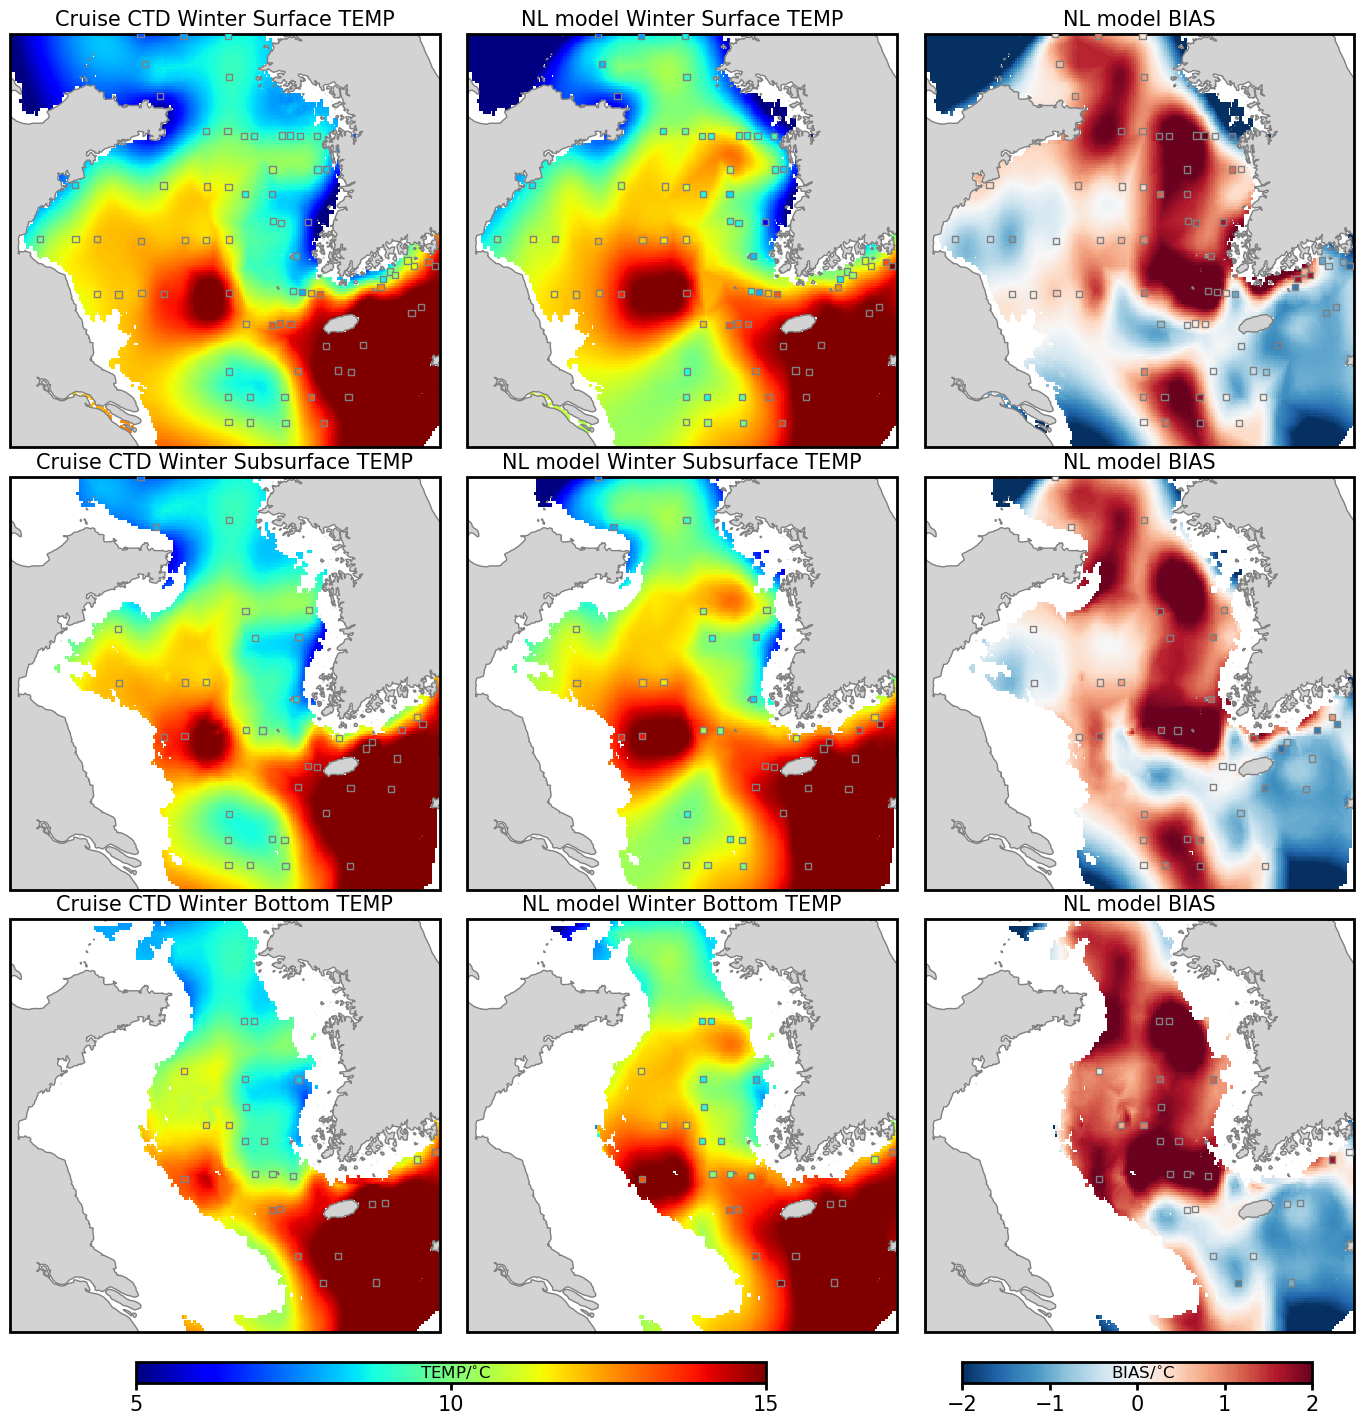

In [434]:
### winter
iseason = 'winter'
icmap = 'jet'
surface = -11 #(d10)
subsurface = -31 #(d30m)
bottom = -52 #(d51m)
imin=5
imax=15
diff_imin = -2
diff_imax = 2
index_valid = np.where(obs_modgrd_seasonal[iseason].notnull().data.ravel())
lon_valid = (lon_rho3d.ravel())[index_valid]
lat_valid = (lat_rho3d.ravel())[index_valid]
depth_valid = (depth_modgrd_seasonal[iseason].data.ravel())[index_valid]
obs_valid = (obs_modgrd_seasonal[iseason].data.ravel())[index_valid]
nl_valid = (nl_modgrd_seasonal[iseason].data.ravel())[index_valid]

axs = []
fig = plt.figure(figsize=(14,14))

spec = fig.add_gridspec(ncols=3, nrows=3)
axs.append(fig.add_subplot(spec[0,0],projection = ccrs.Mercator())) #0
axs.append(fig.add_subplot(spec[0,1],projection = ccrs.Mercator()))  #1
axs.append(fig.add_subplot(spec[0,2],projection = ccrs.Mercator()))  #1

axs.append(fig.add_subplot(spec[1,0],projection = ccrs.Mercator()))  #3
axs.append(fig.add_subplot(spec[1,1],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[1,2],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[2,0],projection = ccrs.Mercator()))  #3
axs.append(fig.add_subplot(spec[2,1],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[2,2],projection = ccrs.Mercator()))  #1
# axs.append(fig.add_subplot(spec[1,2:])) #5
fig.tight_layout(pad=2)

lon_bdy = [lon_itp3d[iseason][-1,:,-1][0],lon_itp3d[iseason][-1,:,-1][-1]]
lat_bdy = [lat_itp3d[iseason][:,-1,-1][0],lat_itp3d[iseason][:,-1,-1][-1]]
#------------------------------------surface 
iax=0
axs[iax].set_title('Cruise CTD %s Surface TEMP'%(iseason.capitalize()),fontsize=15)
depth_index = np.where((depth_valid<=surface+1) & (depth_valid>surface))
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                obs_itp3d[iseason][:,:,surface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)
iax=1
axs[iax].set_title('NL model %s Surface TEMP'%(iseason.capitalize()),fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,surface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)

iax=2
axs[iax].set_title('NL model BIAS',fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,surface]-obs_itp3d[iseason][:,:,surface],
                vmin=diff_imin,vmax=diff_imax,cmap=cmaps.MPL_RdBu_r,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=cmaps.MPL_RdBu_r,
                    transform=ccrs.PlateCarree(),zorder=3)

#------------------------------------subsurface 
iax=3
axs[iax].set_title('Cruise CTD %s Subsurface TEMP'%(iseason.capitalize()),fontsize=15)
depth_index = np.where((depth_valid<=subsurface+1) & (depth_valid>subsurface))
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                obs_itp3d[iseason][:,:,subsurface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)
iax=4
axs[iax].set_title('NL model %s Subsurface TEMP'%(iseason.capitalize()),fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,subsurface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)

iax=5
axs[iax].set_title('NL model BIAS',fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,subsurface]-obs_itp3d[iseason][:,:,subsurface],
                vmin=diff_imin,vmax=diff_imax,cmap=cmaps.MPL_RdBu_r,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=cmaps.MPL_RdBu_r,
                    transform=ccrs.PlateCarree(),zorder=3)


#------------------------------------bottom
iax=6
axs[iax].set_title('Cruise CTD %s Bottom TEMP'%(iseason.capitalize()),fontsize=15)
depth_index = np.where((depth_valid<=bottom+1) & (depth_valid>bottom))
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                obs_itp3d[iseason][:,:,bottom],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)
iax=7
axs[iax].set_title('NL model %s Bottom TEMP'%(iseason.capitalize()),fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,bottom],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)

iax=8
axs[iax].set_title('NL model BIAS',fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,bottom]-obs_itp3d[iseason][:,:,bottom],
                vmin=diff_imin,vmax=diff_imax,cmap=cmaps.MPL_RdBu_r,
                transform=ccrs.PlateCarree(),zorder=-2)
sc_diff = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=cmaps.MPL_RdBu_r,
                    transform=ccrs.PlateCarree(),zorder=3)


#------------------------------------colorbar
# value
position=fig.add_axes([ 0.11, 0,0.45, 0.015, ])
cb = fig.colorbar(sc, cax = position,orientation='horizontal',
                  ticks = np.arange(imin,imax+5,5))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 15)
position.text(9.5,0.2,'TEMP/$\mathsf{^{\circ}C}$',fontsize=12)



#diff 
position=fig.add_axes([ 0.7, 0,0.25, 0.015, ])
cb = fig.colorbar(sc_diff, cax = position,orientation='horizontal',
                  ticks = np.arange(diff_imin,diff_imax+1,1))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 15)
position.text(-0.3,0.2,'BIAS/$\mathsf{^{\circ}C}$',fontsize=12)
plt.savefig('/Volumes/LC_1/fig_thesis/winter_prof_temp_error_h_vcoord_phs2201.png',bbox_inches='tight',dpi=400)
plt.savefig('/Volumes/LC_1/fig_thesis/winter_prof_temp_error_h_vcoord_phs2201.pdf',bbox_inches='tight',dpi=400)

spring temp horizontal  validation

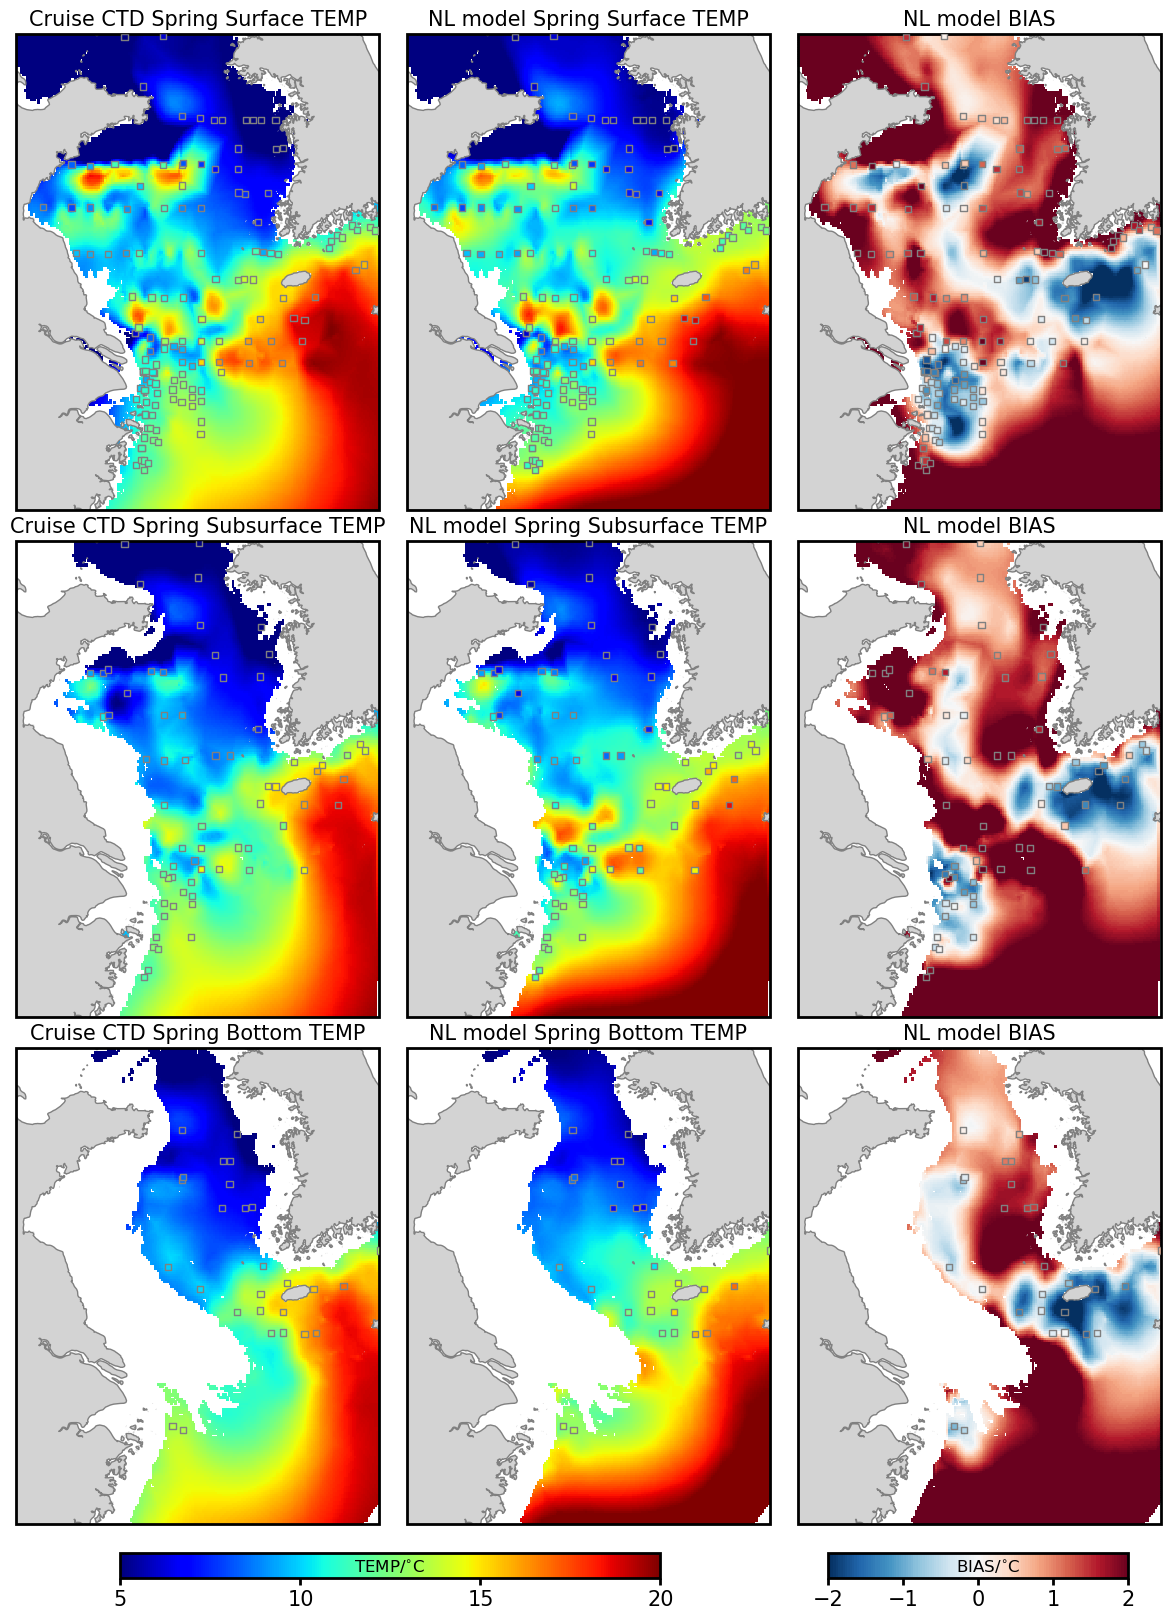

In [49]:
### spring
iseason = 'spring'
icmap = 'jet'
surface = -11 #(d10)
subsurface = -31 #(d30m)
bottom = -54 #(d53m)
imin=5
imax=20
diff_imin = -2
diff_imax = 2
index_valid = np.where(obs_modgrd_seasonal[iseason].notnull().data.ravel())
lon_valid = (lon_rho3d.ravel())[index_valid]
lat_valid = (lat_rho3d.ravel())[index_valid]
depth_valid = (depth_modgrd_seasonal[iseason].data.ravel())[index_valid]
obs_valid = (obs_modgrd_seasonal[iseason].data.ravel())[index_valid]
nl_valid = (nl_modgrd_seasonal[iseason].data.ravel())[index_valid]

axs = []
fig = plt.figure(figsize=(12,17))

spec = fig.add_gridspec(ncols=3, nrows=3)
axs.append(fig.add_subplot(spec[0,0],projection = ccrs.Mercator())) #0
axs.append(fig.add_subplot(spec[0,1],projection = ccrs.Mercator()))  #1
axs.append(fig.add_subplot(spec[0,2],projection = ccrs.Mercator()))  #1

axs.append(fig.add_subplot(spec[1,0],projection = ccrs.Mercator()))  #3
axs.append(fig.add_subplot(spec[1,1],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[1,2],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[2,0],projection = ccrs.Mercator()))  #3
axs.append(fig.add_subplot(spec[2,1],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[2,2],projection = ccrs.Mercator()))  #1
##--------------may change this!!!
fig.tight_layout(pad=2)
##--------------
lon_bdy = [lon_itp3d[iseason][-1,:,-1][0],lon_itp3d[iseason][-1,:,-1][-1]]
lat_bdy = [lat_itp3d[iseason][:,-1,-1][0],lat_itp3d[iseason][:,-1,-1][-1]]
#------------------------------------surface 
iax=0
axs[iax].set_title('Cruise CTD %s Surface TEMP'%(iseason.capitalize()),fontsize=15)
depth_index = np.where((depth_valid<=surface+1) & (depth_valid>surface))
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                obs_itp3d[iseason][:,:,surface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)
iax=1
axs[iax].set_title('NL model %s Surface TEMP'%(iseason.capitalize()),fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,surface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)

iax=2
axs[iax].set_title('NL model BIAS',fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,surface]-obs_itp3d[iseason][:,:,surface],
                vmin=diff_imin,vmax=diff_imax,cmap=cmaps.MPL_RdBu_r,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=cmaps.MPL_RdBu_r,
                    transform=ccrs.PlateCarree(),zorder=3)

#------------------------------------subsurface 
iax=3
axs[iax].set_title('Cruise CTD %s Subsurface TEMP'%(iseason.capitalize()),fontsize=15)
depth_index = np.where((depth_valid<=subsurface+1) & (depth_valid>subsurface))
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                obs_itp3d[iseason][:,:,subsurface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)
iax=4
axs[iax].set_title('NL model %s Subsurface TEMP'%(iseason.capitalize()),fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,subsurface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)

iax=5
axs[iax].set_title('NL model BIAS',fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,subsurface]-obs_itp3d[iseason][:,:,subsurface],
                vmin=diff_imin,vmax=diff_imax,cmap=cmaps.MPL_RdBu_r,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=cmaps.MPL_RdBu_r,
                    transform=ccrs.PlateCarree(),zorder=3)


#------------------------------------bottom
iax=6
axs[iax].set_title('Cruise CTD %s Bottom TEMP'%(iseason.capitalize()),fontsize=15)
depth_index = np.where((depth_valid<=bottom+1) & (depth_valid>bottom))
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                obs_itp3d[iseason][:,:,bottom],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)
iax=7
axs[iax].set_title('NL model %s Bottom TEMP'%(iseason.capitalize()),fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,bottom],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)

iax=8
axs[iax].set_title('NL model BIAS',fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,bottom]-obs_itp3d[iseason][:,:,bottom],
                vmin=diff_imin,vmax=diff_imax,cmap=cmaps.MPL_RdBu_r,
                transform=ccrs.PlateCarree(),zorder=-2)
sc_diff = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=cmaps.MPL_RdBu_r,
                    transform=ccrs.PlateCarree(),zorder=3)


#------------------------------------colorbar
# value
position=fig.add_axes([ 0.11, 0.03,0.45, 0.015, ])
cb = fig.colorbar(sc, cax = position,orientation='horizontal',
                  ticks = np.arange(imin,imax+5,5))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 15)
position.text(11.5,0.2,'TEMP/$\mathsf{^{\circ}C}$',fontsize=12)


#diff 
position=fig.add_axes([ 0.7, 0.03,0.25, 0.015, ])
cb = fig.colorbar(sc_diff, cax = position,orientation='horizontal',
                  ticks = np.arange(diff_imin,diff_imax+1,1))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 15)
position.text(-0.3,0.2,'BIAS/$\mathsf{^{\circ}C}$',fontsize=12)
plt.savefig('/Volumes/LC_1/fig_thesis/%s_prof_temp_error_h_vcoord_phs2201.png'%(iseason),bbox_inches='tight',dpi=400)
plt.savefig('/Volumes/LC_1/fig_thesis/%s_prof_temp_error_h_vcoord_phs2201.pdf'%(iseason),bbox_inches='tight',dpi=400)

summer temp horizontal  validation

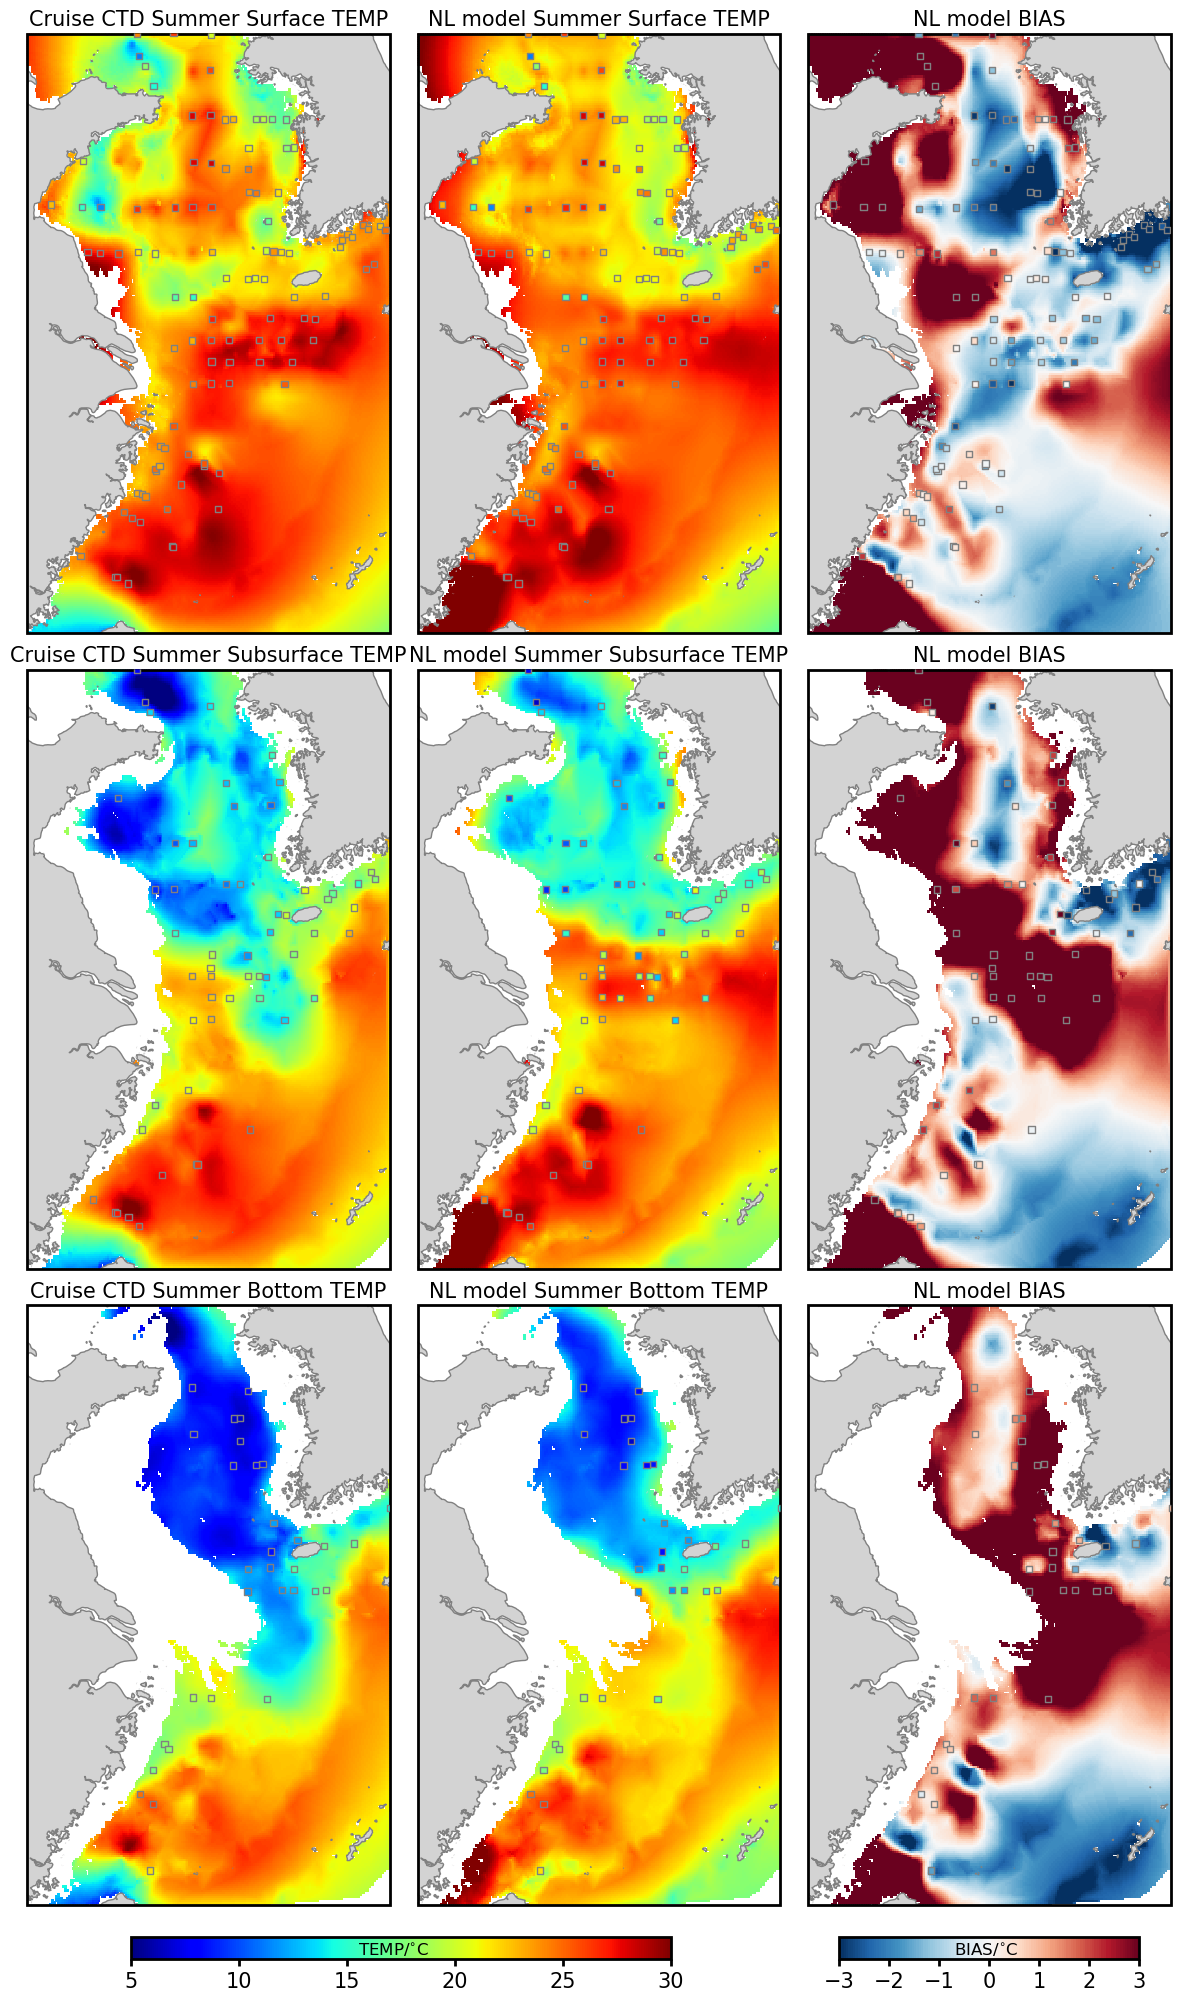

In [51]:
### summer
iseason = 'summer'
icmap = 'jet'
surface = -11 #(d10)
subsurface = -31 #(d30m)
bottom = -54 #(d53m)
imin=5
imax=30
diff_imin = -3
diff_imax = 3
index_valid = np.where(obs_modgrd_seasonal[iseason].notnull().data.ravel())
lon_valid = (lon_rho3d.ravel())[index_valid]
lat_valid = (lat_rho3d.ravel())[index_valid]
depth_valid = (depth_modgrd_seasonal[iseason].data.ravel())[index_valid]
obs_valid = (obs_modgrd_seasonal[iseason].data.ravel())[index_valid]
nl_valid = (nl_modgrd_seasonal[iseason].data.ravel())[index_valid]

axs = []
fig = plt.figure(figsize=(12,22))

spec = fig.add_gridspec(ncols=3, nrows=3)
axs.append(fig.add_subplot(spec[0,0],projection = ccrs.Mercator())) #0
axs.append(fig.add_subplot(spec[0,1],projection = ccrs.Mercator()))  #1
axs.append(fig.add_subplot(spec[0,2],projection = ccrs.Mercator()))  #1

axs.append(fig.add_subplot(spec[1,0],projection = ccrs.Mercator()))  #3
axs.append(fig.add_subplot(spec[1,1],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[1,2],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[2,0],projection = ccrs.Mercator()))  #3
axs.append(fig.add_subplot(spec[2,1],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[2,2],projection = ccrs.Mercator()))  #1
##--------------may change this!!!
fig.tight_layout(pad=2)
##--------------
lon_bdy = [lon_itp3d[iseason][-1,:,-1][0],lon_itp3d[iseason][-1,:,-1][-1]]
lat_bdy = [lat_itp3d[iseason][:,-1,-1][0],lat_itp3d[iseason][:,-1,-1][-1]]
#------------------------------------surface 
iax=0
axs[iax].set_title('Cruise CTD %s Surface TEMP'%(iseason.capitalize()),fontsize=15)
depth_index = np.where((depth_valid<=surface+1) & (depth_valid>surface))
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                obs_itp3d[iseason][:,:,surface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)
iax=1
axs[iax].set_title('NL model %s Surface TEMP'%(iseason.capitalize()),fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,surface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)

iax=2
axs[iax].set_title('NL model BIAS',fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,surface]-obs_itp3d[iseason][:,:,surface],
                vmin=diff_imin,vmax=diff_imax,cmap=cmaps.MPL_RdBu_r,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=cmaps.MPL_RdBu_r,
                    transform=ccrs.PlateCarree(),zorder=3)

#------------------------------------subsurface 
iax=3
axs[iax].set_title('Cruise CTD %s Subsurface TEMP'%(iseason.capitalize()),fontsize=15)
depth_index = np.where((depth_valid<=subsurface+1) & (depth_valid>subsurface))
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                obs_itp3d[iseason][:,:,subsurface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)
iax=4
axs[iax].set_title('NL model %s Subsurface TEMP'%(iseason.capitalize()),fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,subsurface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)

iax=5
axs[iax].set_title('NL model BIAS',fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,subsurface]-obs_itp3d[iseason][:,:,subsurface],
                vmin=diff_imin,vmax=diff_imax,cmap=cmaps.MPL_RdBu_r,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=cmaps.MPL_RdBu_r,
                    transform=ccrs.PlateCarree(),zorder=3)


#------------------------------------bottom
iax=6
axs[iax].set_title('Cruise CTD %s Bottom TEMP'%(iseason.capitalize()),fontsize=15)
depth_index = np.where((depth_valid<=bottom+1) & (depth_valid>bottom))
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                obs_itp3d[iseason][:,:,bottom],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)
iax=7
axs[iax].set_title('NL model %s Bottom TEMP'%(iseason.capitalize()),fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,bottom],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)

iax=8
axs[iax].set_title('NL model BIAS',fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,bottom]-obs_itp3d[iseason][:,:,bottom],
                vmin=diff_imin,vmax=diff_imax,cmap=cmaps.MPL_RdBu_r,
                transform=ccrs.PlateCarree(),zorder=-2)
sc_diff = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=cmaps.MPL_RdBu_r,
                    transform=ccrs.PlateCarree(),zorder=3)


#------------------------------------colorbar
# value
position=fig.add_axes([ 0.11, 0.05,0.45, 0.01, ])
cb = fig.colorbar(sc, cax = position,orientation='horizontal',
                  ticks = np.arange(imin,imax+5,5))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 15)
position.text(15.5,0.2,'TEMP/$\mathsf{^{\circ}C}$',fontsize=12)


#diff 
position=fig.add_axes([ 0.7, 0.05,0.25, 0.01, ])
cb = fig.colorbar(sc_diff, cax = position,orientation='horizontal',
                  ticks = np.arange(diff_imin,diff_imax+1,1))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 15)
position.text(-0.7,0.2,'BIAS/$\mathsf{^{\circ}C}$',fontsize=12)
plt.savefig('/Volumes/LC_1/fig_thesis/%s_prof_temp_error_h_vcoord_phs2201.png'%(iseason),bbox_inches='tight',dpi=400)
plt.savefig('/Volumes/LC_1/fig_thesis/%s_prof_temp_error_h_vcoord_phs2201.pdf'%(iseason),bbox_inches='tight',dpi=400)

autumn temp horizontal  validation

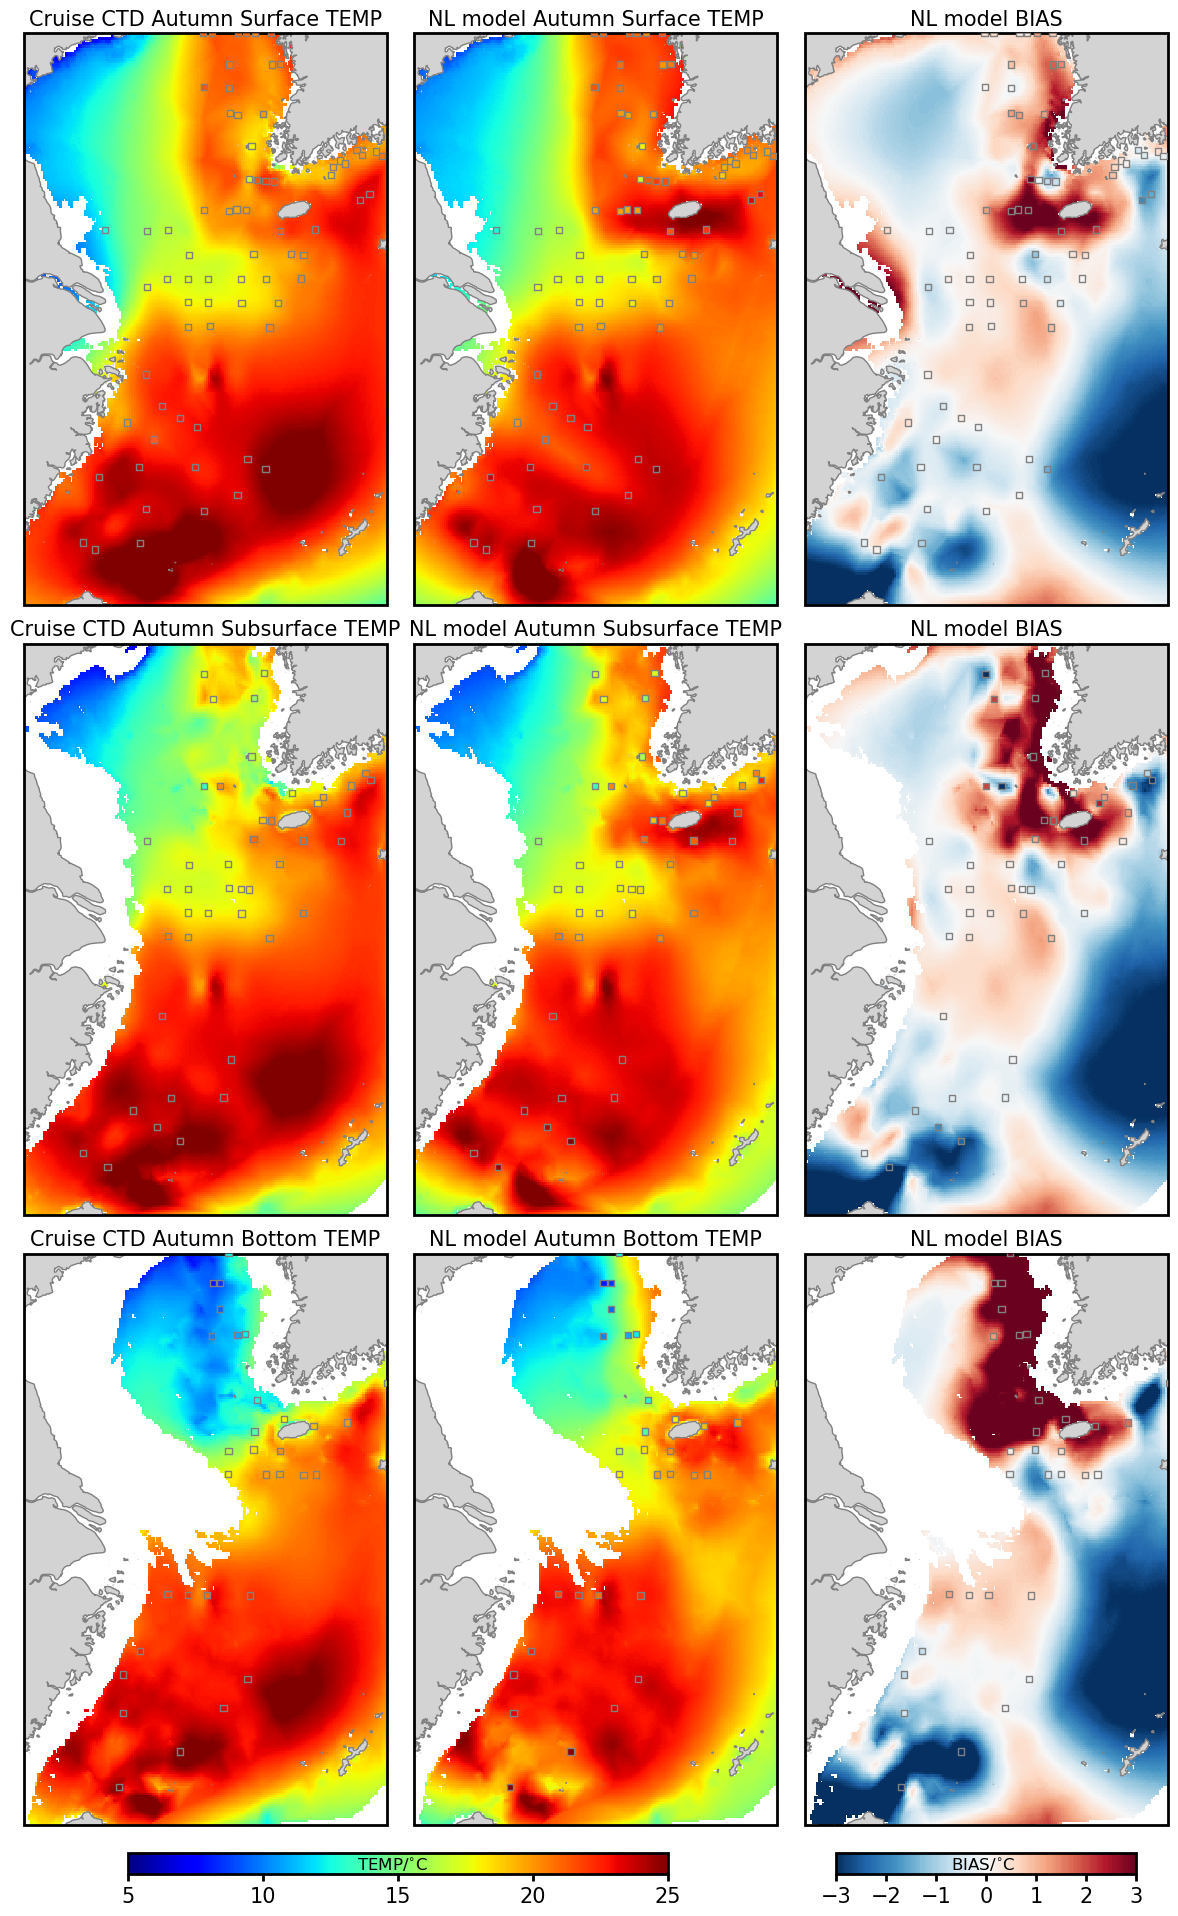

In [53]:
### autumn
iseason = 'autumn'
icmap = 'jet'
surface = -11 #(d10)
subsurface = -31 #(d30m)
bottom = -54 #(d53m)
imin=5
imax=25
diff_imin = -3
diff_imax = 3
index_valid = np.where(obs_modgrd_seasonal[iseason].notnull().data.ravel())
lon_valid = (lon_rho3d.ravel())[index_valid]
lat_valid = (lat_rho3d.ravel())[index_valid]
depth_valid = (depth_modgrd_seasonal[iseason].data.ravel())[index_valid]
obs_valid = (obs_modgrd_seasonal[iseason].data.ravel())[index_valid]
nl_valid = (nl_modgrd_seasonal[iseason].data.ravel())[index_valid]

axs = []
fig = plt.figure(figsize=(12,21))

spec = fig.add_gridspec(ncols=3, nrows=3)
axs.append(fig.add_subplot(spec[0,0],projection = ccrs.Mercator())) #0
axs.append(fig.add_subplot(spec[0,1],projection = ccrs.Mercator()))  #1
axs.append(fig.add_subplot(spec[0,2],projection = ccrs.Mercator()))  #1

axs.append(fig.add_subplot(spec[1,0],projection = ccrs.Mercator()))  #3
axs.append(fig.add_subplot(spec[1,1],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[1,2],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[2,0],projection = ccrs.Mercator()))  #3
axs.append(fig.add_subplot(spec[2,1],projection = ccrs.Mercator()))  #4
axs.append(fig.add_subplot(spec[2,2],projection = ccrs.Mercator()))  #1
##--------------may change this!!!
fig.tight_layout(pad=2)
##--------------
lon_bdy = [lon_itp3d[iseason][-1,:,-1][0],lon_itp3d[iseason][-1,:,-1][-1]]
lat_bdy = [lat_itp3d[iseason][:,-1,-1][0],lat_itp3d[iseason][:,-1,-1][-1]]
#------------------------------------surface 
iax=0
axs[iax].set_title('Cruise CTD %s Surface TEMP'%(iseason.capitalize()),fontsize=15)
depth_index = np.where((depth_valid<=surface+1) & (depth_valid>surface))
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                obs_itp3d[iseason][:,:,surface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)
iax=1
axs[iax].set_title('NL model %s Surface TEMP'%(iseason.capitalize()),fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,surface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)

iax=2
axs[iax].set_title('NL model BIAS',fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,surface]-obs_itp3d[iseason][:,:,surface],
                vmin=diff_imin,vmax=diff_imax,cmap=cmaps.MPL_RdBu_r,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=cmaps.MPL_RdBu_r,
                    transform=ccrs.PlateCarree(),zorder=3)

#------------------------------------subsurface 
iax=3
axs[iax].set_title('Cruise CTD %s Subsurface TEMP'%(iseason.capitalize()),fontsize=15)
depth_index = np.where((depth_valid<=subsurface+1) & (depth_valid>subsurface))
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                obs_itp3d[iseason][:,:,subsurface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)
iax=4
axs[iax].set_title('NL model %s Subsurface TEMP'%(iseason.capitalize()),fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,subsurface],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)

iax=5
axs[iax].set_title('NL model BIAS',fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,subsurface]-obs_itp3d[iseason][:,:,subsurface],
                vmin=diff_imin,vmax=diff_imax,cmap=cmaps.MPL_RdBu_r,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=cmaps.MPL_RdBu_r,
                    transform=ccrs.PlateCarree(),zorder=3)


#------------------------------------bottom
iax=6
axs[iax].set_title('Cruise CTD %s Bottom TEMP'%(iseason.capitalize()),fontsize=15)
depth_index = np.where((depth_valid<=bottom+1) & (depth_valid>bottom))
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                obs_itp3d[iseason][:,:,bottom],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)
iax=7
axs[iax].set_title('NL model %s Bottom TEMP'%(iseason.capitalize()),fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,bottom],
                vmin=imin,vmax=imax,cmap=icmap,
                transform=ccrs.PlateCarree(),zorder=-2)
sc = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    transform=ccrs.PlateCarree(),zorder=3)

iax=8
axs[iax].set_title('NL model BIAS',fontsize=15)
set_area_pcolor_bg(lon_bdy,lat_bdy,axs[iax])
pc = axs[iax].pcolor(lon_itp3d[iseason][:,:,-1],lat_itp3d[iseason][:,:,-1],
                nl_itp3d[iseason][:,:,bottom]-obs_itp3d[iseason][:,:,bottom],
                vmin=diff_imin,vmax=diff_imax,cmap=cmaps.MPL_RdBu_r,
                transform=ccrs.PlateCarree(),zorder=-2)
sc_diff = axs[iax].scatter(lon_valid[depth_index],
                    lat_valid[depth_index],
                    s=20,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=cmaps.MPL_RdBu_r,
                    transform=ccrs.PlateCarree(),zorder=3)


#------------------------------------colorbar
# value
position=fig.add_axes([ 0.11, 0.05,0.45, 0.01, ])
cb = fig.colorbar(sc, cax = position,orientation='horizontal',
                  ticks = np.arange(imin,imax+5,5))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 15)
position.text(13.5,0.2,'TEMP/$\mathsf{^{\circ}C}$',fontsize=12)


#diff 
position=fig.add_axes([ 0.7, 0.05,0.25, 0.01, ])
cb = fig.colorbar(sc_diff, cax = position,orientation='horizontal',
                  ticks = np.arange(diff_imin,diff_imax+1,1))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 15)
position.text(-0.7,0.2,'BIAS/$\mathsf{^{\circ}C}$',fontsize=12)
plt.savefig('/Volumes/LC_1/fig_thesis/%s_prof_temp_error_h_vcoord_phs2201.png'%(iseason),bbox_inches='tight',dpi=400)
plt.savefig('/Volumes/LC_1/fig_thesis/%s_prof_temp_error_h_vcoord_phs2201.pdf'%(iseason),bbox_inches='tight',dpi=400)

winter cross section temp validation

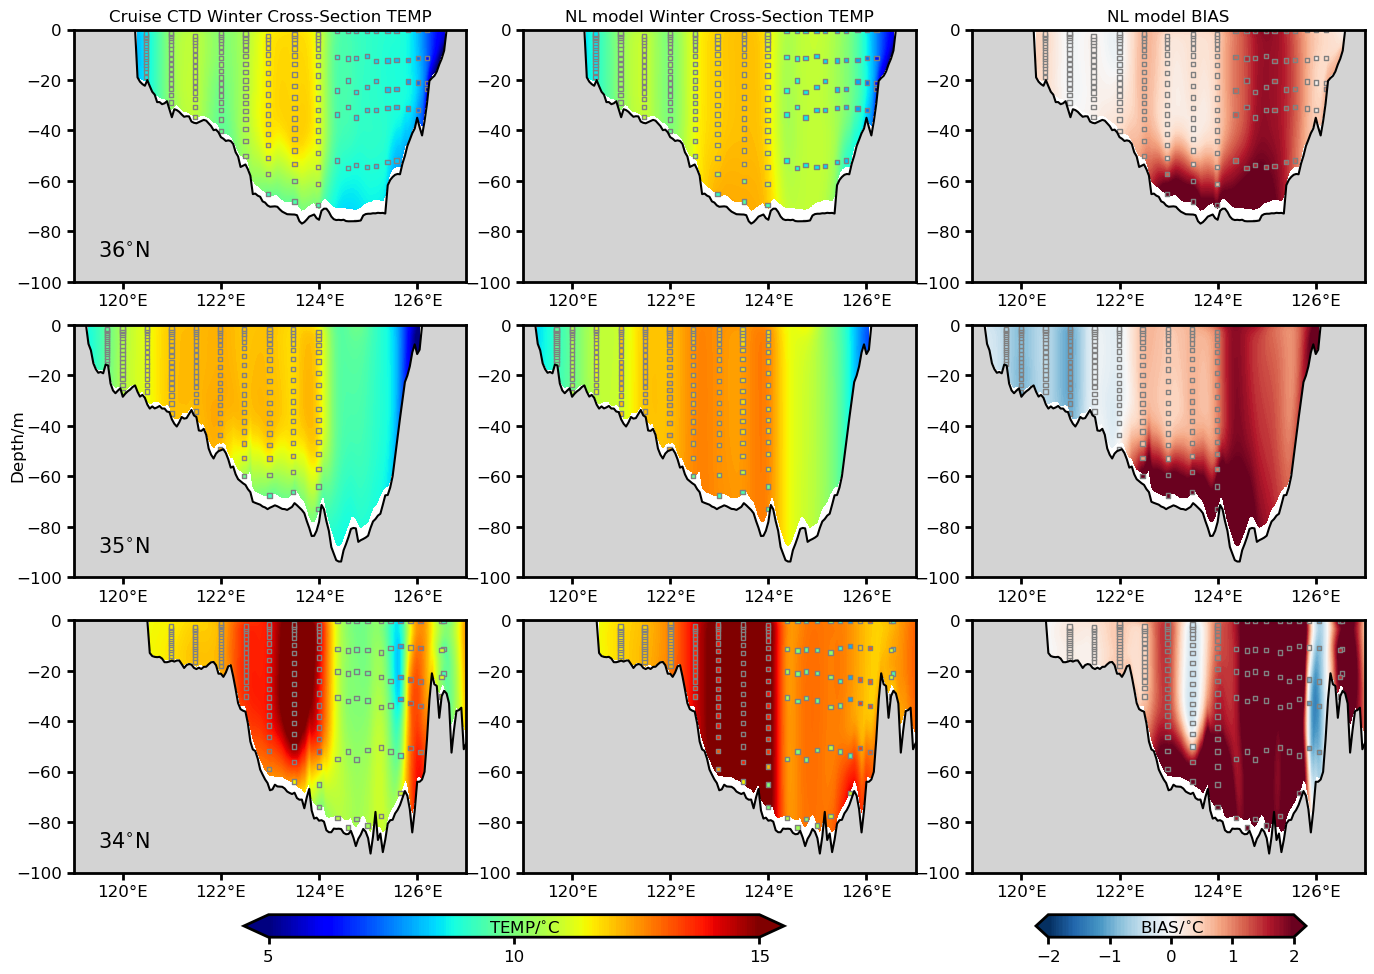

In [55]:
# %matplotlib inline
# winter section 
axs = []
fig = plt.figure(figsize=(18,9))
spec = fig.add_gridspec(ncols=4, nrows=3)
axs.append(fig.add_subplot(spec[0,0])) #0
axs.append(fig.add_subplot(spec[0,1]))  #1
axs.append(fig.add_subplot(spec[0,2]))  #1
axs.append(fig.add_subplot(spec[1,0]))  #3
axs.append(fig.add_subplot(spec[1,1]))  #4
axs.append(fig.add_subplot(spec[1,2]))  #4
axs.append(fig.add_subplot(spec[2,0]))  #3
axs.append(fig.add_subplot(spec[2,1]))  #4
axs.append(fig.add_subplot(spec[2,2]))  #4

fig.tight_layout(pad=1)



iseason = 'winter'
imin = 5
imax = 15
icmap = 'jet'
diff_imin=-2
diff_imax=2
diff_icmap = cmaps.MPL_RdBu_r
index_valid = np.where(obs_modgrd_seasonal[iseason].notnull().data.ravel())
lon_valid = (lon_rho3d.ravel())[index_valid]
lat_valid = (lat_rho3d.ravel())[index_valid]
depth_valid = (depth_modgrd_seasonal[iseason].data.ravel())[index_valid]
obs_valid = (obs_modgrd_seasonal[iseason].data.ravel())[index_valid]
nl_valid = (nl_modgrd_seasonal[iseason].data.ravel())[index_valid]
#####------------observation
iax=0
ilat = 36.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       obs_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].text(119.5,-90,'%i$\mathsf{^{\circ}N}$'%(ilat),fontsize=15)
axs[iax].set_title('Cruise CTD %s Cross-Section TEMP'%(iseason.capitalize()),fontsize=12)

iax=3
ilat = 35.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       obs_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].text(119.5,-90,'%i$\mathsf{^{\circ}N}$'%(ilat),fontsize=15)


iax=6
ilat = 34.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       obs_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].text(119.5,-90,'%i$\mathsf{^{\circ}N}$'%(ilat),fontsize=15)


#####------------nonlinear
iax=1
ilat = 36.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].set_title('NL model %s Cross-Section TEMP'%(iseason.capitalize()),fontsize=12)
iax=4
ilat = 35.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])

iax=7
ilat = 34.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])

###-------------------- diff
iax=2
ilat = 36.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:]-obs_itpv[iseason][lat_index,:,:],
                       cmap=diff_icmap,levels=np.linspace(diff_imin,diff_imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=diff_icmap
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].set_title('NL model BIAS',fontsize=12)

iax=5
ilat = 35.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:]-obs_itpv[iseason][lat_index,:,:],
                       cmap=diff_icmap,levels=np.linspace(diff_imin,diff_imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=diff_icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])

iax=8
ilat = 34.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf_diff = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:]-obs_itpv[iseason][lat_index,:,:],
                       cmap=diff_icmap,levels=np.linspace(diff_imin,diff_imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=diff_icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])



#------------------------------------colorbar
# value
position=fig.add_axes([ 0.12, -0.03,0.3, 0.025, ])
cb = fig.colorbar(cf, cax = position,orientation='horizontal',
                  ticks = np.arange(imin,imax+5,5))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 12)
position.text(9.5,0.2,'TEMP/$\mathsf{^{\circ}C}$',fontsize=12,)


#diff 
position=fig.add_axes([ 0.56, -0.03,0.15, 0.025, ])
cb = fig.colorbar(cf_diff, cax = position,orientation='horizontal',
                  ticks = np.arange(diff_imin,diff_imax+1,1))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 12)
position.text(-0.5,0.2,'BIAS/$\mathsf{^{\circ}C}$',fontsize=12)

fig.text(-0.01,0.48,'Depth/m',rotation='vertical',fontsize = 12)
# plt.show()
plt.savefig('/Volumes/LC_1/fig_thesis/%s_prof_temp_error_v_vcoord_phs2201.png'%(iseason),bbox_inches='tight',dpi=400)
plt.savefig('/Volumes/LC_1/fig_thesis/%s_prof_temp_error_v_vcoord_phs2201.pdf'%(iseason),bbox_inches='tight',dpi=400)

spring cross section temp validation

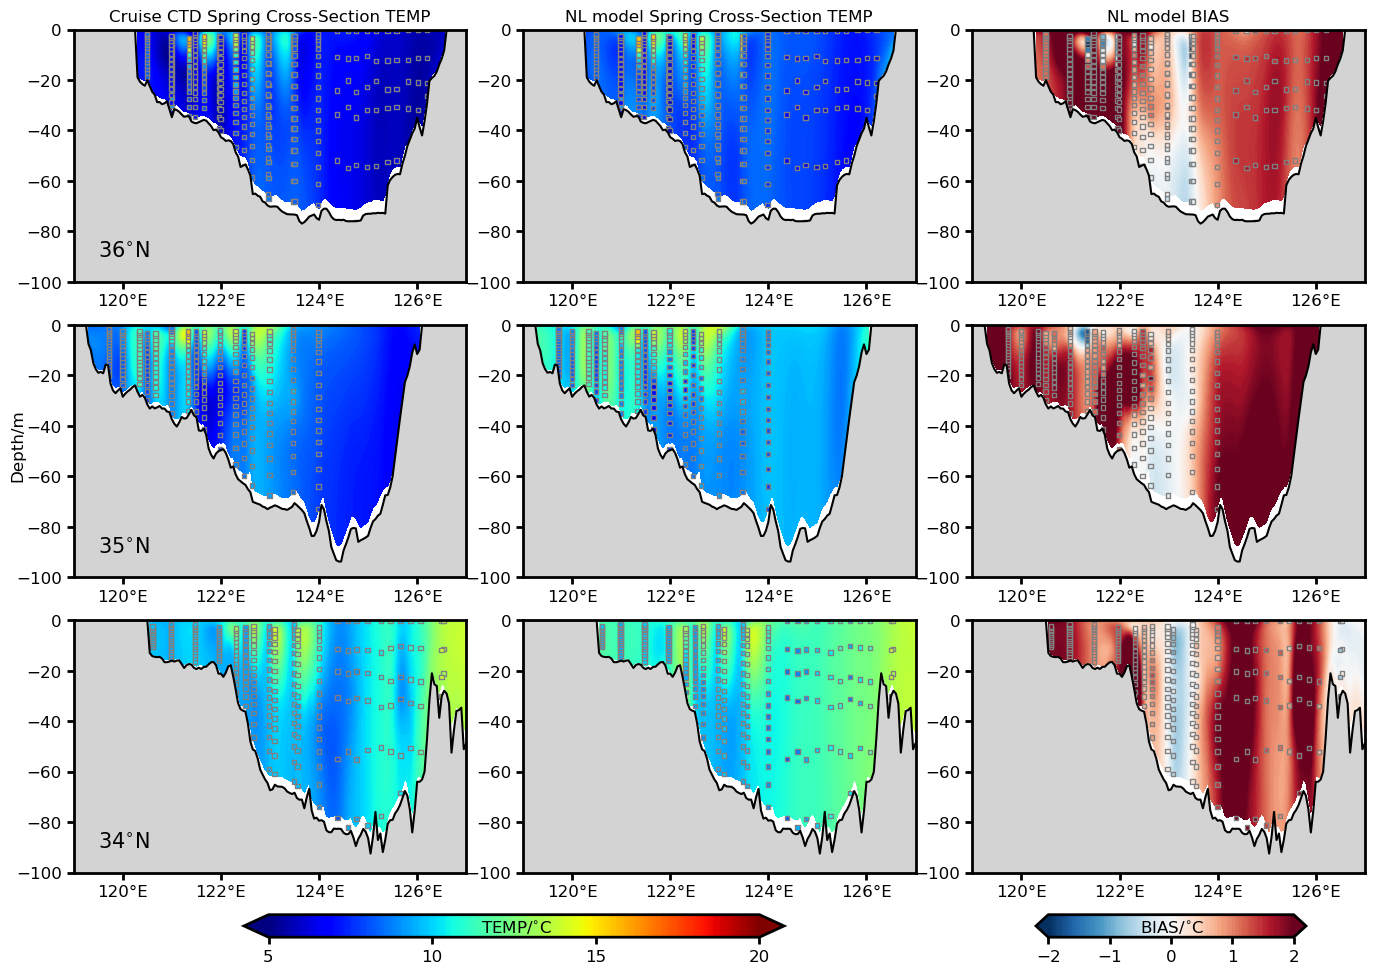

In [48]:
# spring section 
axs = []
fig = plt.figure(figsize=(18,9))
spec = fig.add_gridspec(ncols=4, nrows=3)
axs.append(fig.add_subplot(spec[0,0])) #0
axs.append(fig.add_subplot(spec[0,1]))  #1
axs.append(fig.add_subplot(spec[0,2]))  #1
axs.append(fig.add_subplot(spec[1,0]))  #3
axs.append(fig.add_subplot(spec[1,1]))  #4
axs.append(fig.add_subplot(spec[1,2]))  #4
axs.append(fig.add_subplot(spec[2,0]))  #3
axs.append(fig.add_subplot(spec[2,1]))  #4
axs.append(fig.add_subplot(spec[2,2]))  #4

fig.tight_layout(pad=1)



iseason = 'spring'
imin = 5
imax = 20
imap = 'jet'
diff_imin=-2
diff_imax=2
diff_imap = cmaps.MPL_RdBu_r
index_valid = np.where(obs_modgrd_seasonal[iseason].notnull().data.ravel())
lon_valid = (lon_rho3d.ravel())[index_valid]
lat_valid = (lat_rho3d.ravel())[index_valid]
depth_valid = (depth_modgrd_seasonal[iseason].data.ravel())[index_valid]
obs_valid = (obs_modgrd_seasonal[iseason].data.ravel())[index_valid]
nl_valid = (nl_modgrd_seasonal[iseason].data.ravel())[index_valid]
#####------------observation
iax=0
ilat = 36.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       obs_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].text(119.5,-90,'%i$\mathsf{^{\circ}N}$'%(ilat),fontsize=15)
axs[iax].set_title('Cruise CTD %s Cross-Section TEMP'%(iseason.capitalize()),fontsize=12)

iax=3
ilat = 35.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       obs_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].text(119.5,-90,'%i$\mathsf{^{\circ}N}$'%(ilat),fontsize=15)


iax=6
ilat = 34.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       obs_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].text(119.5,-90,'%i$\mathsf{^{\circ}N}$'%(ilat),fontsize=15)


#####------------nonlinear
iax=1
ilat = 36.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].set_title('NL model %s Cross-Section TEMP'%(iseason.capitalize()),fontsize=12)
iax=4
ilat = 35.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])

iax=7
ilat = 34.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])

###-------------------- diff
iax=2
ilat = 36.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:]-obs_itpv[iseason][lat_index,:,:],
                       cmap=diff_icmap,levels=np.linspace(diff_imin,diff_imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=diff_icmap
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].set_title('NL model BIAS',fontsize=12)

iax=5
ilat = 35.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:]-obs_itpv[iseason][lat_index,:,:],
                       cmap=diff_icmap,levels=np.linspace(diff_imin,diff_imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=diff_icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])

iax=8
ilat = 34.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf_diff = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:]-obs_itpv[iseason][lat_index,:,:],
                       cmap=diff_icmap,levels=np.linspace(diff_imin,diff_imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=diff_icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])



#------------------------------------colorbar
# value
position=fig.add_axes([ 0.12, -0.03,0.3, 0.025, ])
cb = fig.colorbar(cf, cax = position,orientation='horizontal',
                  ticks = np.arange(imin,imax+5,5))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 12)
position.text(11.5,0.2,'TEMP/$\mathsf{^{\circ}C}$',fontsize=12,)


#diff 
position=fig.add_axes([ 0.56, -0.03,0.15, 0.025, ])
cb = fig.colorbar(cf_diff, cax = position,orientation='horizontal',
                  ticks = np.arange(diff_imin,diff_imax+1,1))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 12)
position.text(-0.5,0.2,'BIAS/$\mathsf{^{\circ}C}$',fontsize=12)

fig.text(-0.01,0.48,'Depth/m',rotation='vertical',fontsize = 12)
plt.savefig('/Volumes/LC_1/fig_thesis/%s_prof_temp_error_v_vcoord_phs2201.png'%(iseason),bbox_inches='tight',dpi=400)
plt.savefig('/Volumes/LC_1/fig_thesis/%s_prof_temp_error_v_vcoord_phs2201.pdf'%(iseason),bbox_inches='tight',dpi=400)

summer cross section temp validation

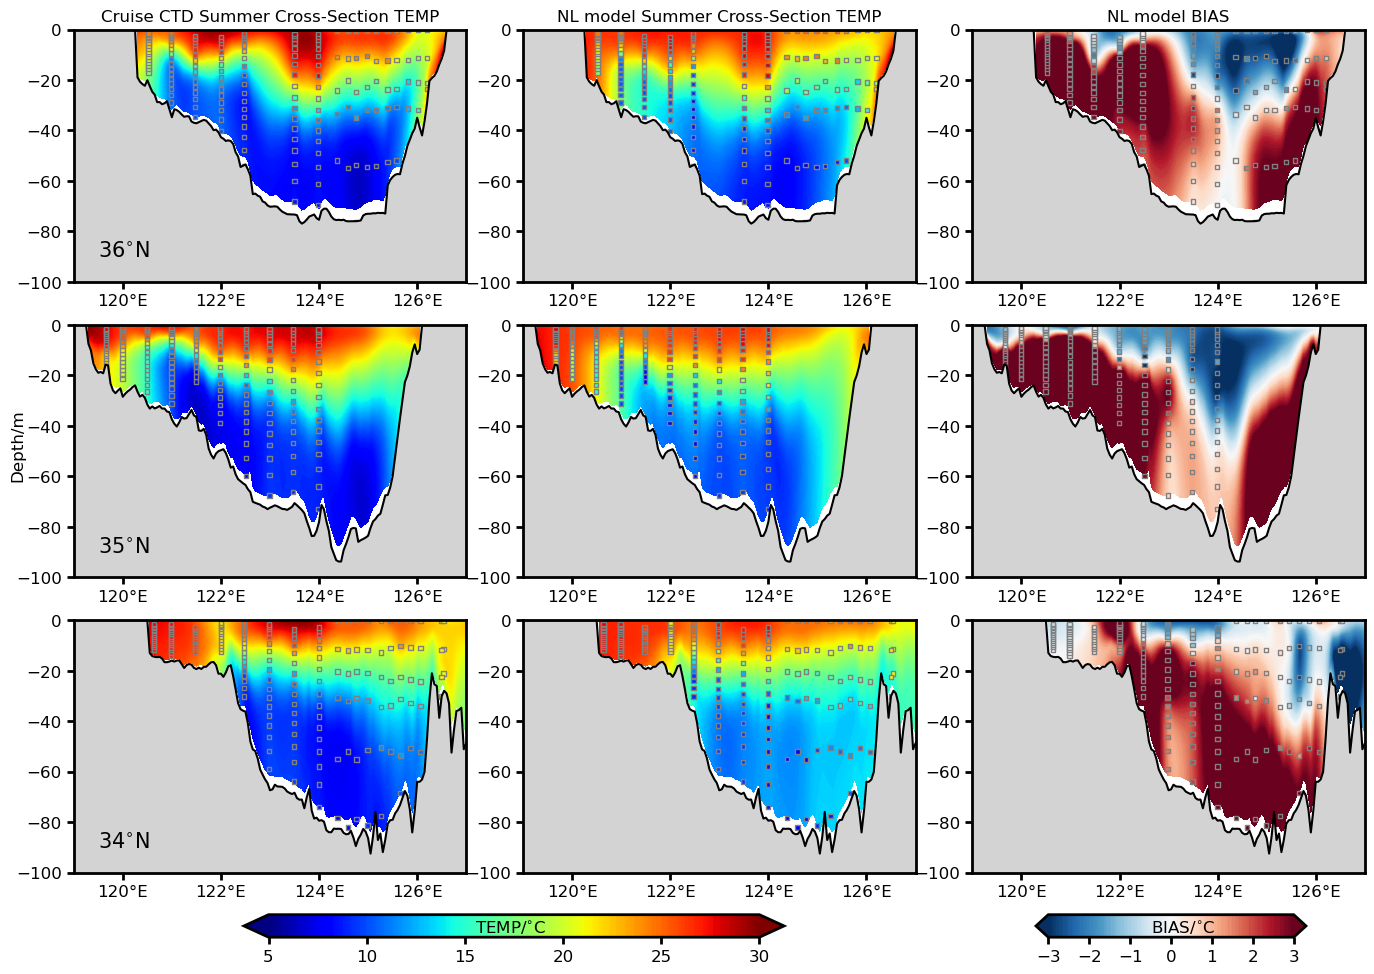

In [50]:
# summer section 
axs = []
fig = plt.figure(figsize=(18,9))
spec = fig.add_gridspec(ncols=4, nrows=3)
axs.append(fig.add_subplot(spec[0,0])) #0
axs.append(fig.add_subplot(spec[0,1]))  #1
axs.append(fig.add_subplot(spec[0,2]))  #1
axs.append(fig.add_subplot(spec[1,0]))  #3
axs.append(fig.add_subplot(spec[1,1]))  #4
axs.append(fig.add_subplot(spec[1,2]))  #4
axs.append(fig.add_subplot(spec[2,0]))  #3
axs.append(fig.add_subplot(spec[2,1]))  #4
axs.append(fig.add_subplot(spec[2,2]))  #4

fig.tight_layout(pad=1)



iseason = 'summer'
imin = 5
imax = 30
imap = 'jet'
diff_imin=-3
diff_imax=3
diff_imap = cmaps.MPL_RdBu_r
index_valid = np.where(obs_modgrd_seasonal[iseason].notnull().data.ravel())
lon_valid = (lon_rho3d.ravel())[index_valid]
lat_valid = (lat_rho3d.ravel())[index_valid]
depth_valid = (depth_modgrd_seasonal[iseason].data.ravel())[index_valid]
obs_valid = (obs_modgrd_seasonal[iseason].data.ravel())[index_valid]
nl_valid = (nl_modgrd_seasonal[iseason].data.ravel())[index_valid]
#####------------observation
iax=0
ilat = 36.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       obs_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].text(119.5,-90,'%i$\mathsf{^{\circ}N}$'%(ilat),fontsize=15)
axs[iax].set_title('Cruise CTD %s Cross-Section TEMP'%(iseason.capitalize()),fontsize=12)

iax=3
ilat = 35.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       obs_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].text(119.5,-90,'%i$\mathsf{^{\circ}N}$'%(ilat),fontsize=15)


iax=6
ilat = 34.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       obs_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].text(119.5,-90,'%i$\mathsf{^{\circ}N}$'%(ilat),fontsize=15)


#####------------nonlinear
iax=1
ilat = 36.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].set_title('NL model %s Cross-Section TEMP'%(iseason.capitalize()),fontsize=12)
iax=4
ilat = 35.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])

iax=7
ilat = 34.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])

###-------------------- diff
iax=2
ilat = 36.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:]-obs_itpv[iseason][lat_index,:,:],
                       cmap=diff_icmap,levels=np.linspace(diff_imin,diff_imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=diff_icmap
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].set_title('NL model BIAS',fontsize=12)

iax=5
ilat = 35.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:]-obs_itpv[iseason][lat_index,:,:],
                       cmap=diff_icmap,levels=np.linspace(diff_imin,diff_imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=diff_icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])

iax=8
ilat = 34.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf_diff = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:]-obs_itpv[iseason][lat_index,:,:],
                       cmap=diff_icmap,levels=np.linspace(diff_imin,diff_imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=diff_icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])



#------------------------------------colorbar
# value
position=fig.add_axes([ 0.12, -0.03,0.3, 0.025, ])
cb = fig.colorbar(cf, cax = position,orientation='horizontal',
                  ticks = np.arange(imin,imax+5,5))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 12)
position.text(15.5,0.2,'TEMP/$\mathsf{^{\circ}C}$',fontsize=12,)


#diff 
position=fig.add_axes([ 0.56, -0.03,0.15, 0.025, ])
cb = fig.colorbar(cf_diff, cax = position,orientation='horizontal',
                  ticks = np.arange(diff_imin,diff_imax+1,1))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 12)
position.text(-0.5,0.2,'BIAS/$\mathsf{^{\circ}C}$',fontsize=12)

fig.text(-0.01,0.48,'Depth/m',rotation='vertical',fontsize = 12)
plt.savefig('/Volumes/LC_1/fig_thesis/%s_prof_temp_error_v_vcoord_phs2201.png'%(iseason),bbox_inches='tight',dpi=400)
plt.savefig('/Volumes/LC_1/fig_thesis/%s_prof_temp_error_v_vcoord_phs2201.pdf'%(iseason),bbox_inches='tight',dpi=400)

 autumn cross section temp validation

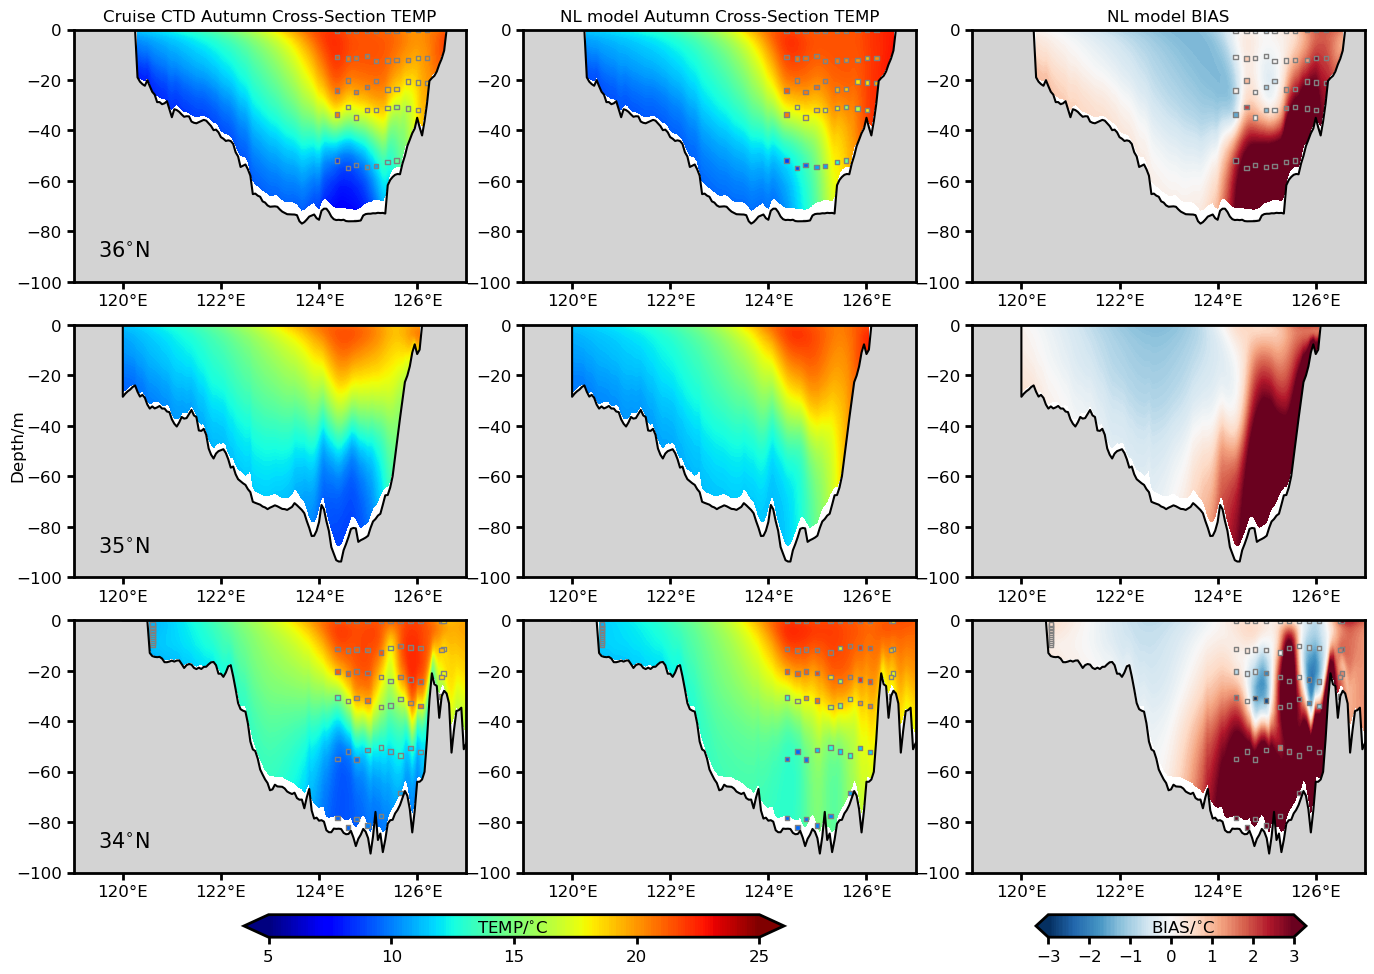

In [52]:
# autumn section 
axs = []
fig = plt.figure(figsize=(18,9))
spec = fig.add_gridspec(ncols=4, nrows=3)
axs.append(fig.add_subplot(spec[0,0])) #0
axs.append(fig.add_subplot(spec[0,1]))  #1
axs.append(fig.add_subplot(spec[0,2]))  #1
axs.append(fig.add_subplot(spec[1,0]))  #3
axs.append(fig.add_subplot(spec[1,1]))  #4
axs.append(fig.add_subplot(spec[1,2]))  #4
axs.append(fig.add_subplot(spec[2,0]))  #3
axs.append(fig.add_subplot(spec[2,1]))  #4
axs.append(fig.add_subplot(spec[2,2]))  #4

fig.tight_layout(pad=1)



iseason = 'autumn'
imin = 5
imax = 25
imap = 'jet'
diff_imin=-3
diff_imax=3
diff_imap = cmaps.MPL_RdBu_r
index_valid = np.where(obs_modgrd_seasonal[iseason].notnull().data.ravel())
lon_valid = (lon_rho3d.ravel())[index_valid]
lat_valid = (lat_rho3d.ravel())[index_valid]
depth_valid = (depth_modgrd_seasonal[iseason].data.ravel())[index_valid]
obs_valid = (obs_modgrd_seasonal[iseason].data.ravel())[index_valid]
nl_valid = (nl_modgrd_seasonal[iseason].data.ravel())[index_valid]
#####------------observation
iax=0
ilat = 36.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       obs_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].text(119.5,-90,'%i$\mathsf{^{\circ}N}$'%(ilat),fontsize=15)
axs[iax].set_title('Cruise CTD %s Cross-Section TEMP'%(iseason.capitalize()),fontsize=12)

iax=3
ilat = 35.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       obs_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].text(119.5,-90,'%i$\mathsf{^{\circ}N}$'%(ilat),fontsize=15)


iax=6
ilat = 34.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       obs_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].text(119.5,-90,'%i$\mathsf{^{\circ}N}$'%(ilat),fontsize=15)


#####------------nonlinear
iax=1
ilat = 36.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].set_title('NL model %s Cross-Section TEMP'%(iseason.capitalize()),fontsize=12)
iax=4
ilat = 35.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])

iax=7
ilat = 34.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:],
                       cmap=icmap,levels=np.linspace(imin,imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=obs_valid[depth_index],
                    marker = 's',vmin=imin,vmax=imax,edgecolor='gray',cmap=icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])

###-------------------- diff
iax=2
ilat = 36.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0

axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:]-obs_itpv[iseason][lat_index,:,:],
                       cmap=diff_icmap,levels=np.linspace(diff_imin,diff_imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=diff_icmap
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])
axs[iax].set_title('NL model BIAS',fontsize=12)

iax=5
ilat = 35.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:]-obs_itpv[iseason][lat_index,:,:],
                       cmap=diff_icmap,levels=np.linspace(diff_imin,diff_imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=diff_icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])

iax=8
ilat = 34.
depth_index = np.where((lat_valid<=ilat+0.2) & (lat_valid>ilat-0.2))
set_lonsection_bg(axs[iax])
lat_index =  np.abs(lat_itpv[iseason][:,0,0] - ilat).argmin()
bath_thissection = bath_itpv[iseason][lat_index,:,-1]
lon_thissection = lon_itpv[iseason][lat_index,:,-1]
bath_thissection[bath_thissection == 7.5] = 0
cf_diff = axs[iax].contourf(lon_itpv[iseason][lat_index,:,:],
                       depth_itpv[iseason][lat_index,:,:],
                       nl_itpv[iseason][lat_index,:,:]-obs_itpv[iseason][lat_index,:,:],
                       cmap=diff_icmap,levels=np.linspace(diff_imin,diff_imax,200),extend='both')
axs[iax].scatter(lon_valid[depth_index],
                    depth_valid[depth_index],
                    s=10,
                    c=nl_valid[depth_index]-obs_valid[depth_index],
                    marker = 's',vmin=diff_imin,vmax=diff_imax,edgecolor='gray',cmap=diff_icmap,
                    )
plot_lonsection_bath(axs[iax],lon_thissection,bath_thissection)
# plt.colorbar(cf)
axs[iax].set_xlim([119,127])
axs[iax].set_ylim([-100,0])



#------------------------------------colorbar
# value
position=fig.add_axes([ 0.12, -0.03,0.3, 0.025, ])
cb = fig.colorbar(cf, cax = position,orientation='horizontal',
                  ticks = np.arange(imin,imax+5,5))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 12)
position.text(13.5,0.2,'TEMP/$\mathsf{^{\circ}C}$',fontsize=12,)


#diff 
position=fig.add_axes([ 0.56, -0.03,0.15, 0.025, ])
cb = fig.colorbar(cf_diff, cax = position,orientation='horizontal',
                  ticks = np.arange(diff_imin,diff_imax+1,1))
for bnd in position.spines.keys():
    position.spines[bnd].set_linewidth(2)
position.tick_params(direction = 'out', length =5, width = 2, labelsize = 12)
position.text(-0.5,0.2,'BIAS/$\mathsf{^{\circ}C}$',fontsize=12)

fig.text(-0.01,0.48,'Depth/m',rotation='vertical',fontsize = 12)
plt.savefig('/Volumes/LC_1/fig_thesis/%s_prof_temp_error_v_vcoord_phs2201.png'%(iseason),bbox_inches='tight',dpi=400)
plt.savefig('/Volumes/LC_1/fig_thesis/%s_prof_temp_error_v_vcoord_phs2201.pdf'%(iseason),bbox_inches='tight',dpi=400)